In [2]:
import random 
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image

import tensorflow as tf

%matplotlib inline
import data_utils
    
#conf = tf.ConfigProto()
#conf.gpu_options.per_process_gpu_memory_fraction = 0.2
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
X, Y = data_utils.get_train_batch(5)

In [4]:
X.shape

(5, 10, 64, 64, 3)

In [5]:
"""t = tf.constant( [[ [1,2,3], [4,5,6] ] , [ [11,12,13], [14,15,16] ] ] )
print(t)
print(t[:,1:2])
with tf.Session() as sess:
    print(sess.run(t[:,1:2]))
    """

't = tf.constant( [[ [1,2,3], [4,5,6] ] , [ [11,12,13], [14,15,16] ] ] )\nprint(t)\nprint(t[:,1:2])\nwith tf.Session() as sess:\n    print(sess.run(t[:,1:2]))\n    '

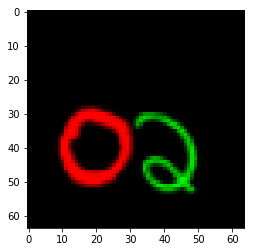

In [6]:
plt.imshow(X[0][0])
plt.imshow(X[0][1])

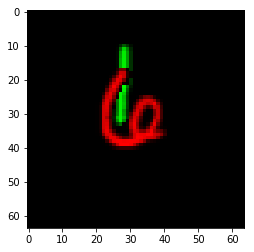

In [7]:
plt.imshow(X[0:3].reshape(-1,64,64,3)[15])

In [8]:
"""
dir='Data/train_sequence/'
n_seq = 10000

data_path_list =[ os.path.join(dir, 'sequence%04d' % idx) for idx in range(n_seq) ] 
print(data_path_list[:3])

path = data_path_list[23]

def read_image(path):
    data = np.zeros([ 20, 64, 64, 3],dtype=np.float32)
    path=path.decode("utf-8")
    for t in range(20):
        img_path = os.path.join(path, 'frames%02d.png'% t) 
        data[t] = np.array(Image.open(img_path)) / 255.0
    
    return data

plt.imshow(read_image(path.encode())[3])

batch_size = 200

dataset = tf.data.Dataset.from_tensor_slices(data_path_list)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=4000)
dataset = dataset.map( lambda data_path_list: tf.py_func(read_image, [data_path_list], tf.float32))
dataset = dataset.batch(batch_size)

iterator = dataset.make_initializable_iterator()
image_batch = iterator.get_next()


with tf.Session() as sess:
    sess.run(iterator.initializer)
    batch_X = sess.run(image_batch)
    """
    

'\ndir=\'Data/train_sequence/\'\nn_seq = 10000\n\ndata_path_list =[ os.path.join(dir, \'sequence%04d\' % idx) for idx in range(n_seq) ] \nprint(data_path_list[:3])\n\npath = data_path_list[23]\n\ndef read_image(path):\n    data = np.zeros([ 20, 64, 64, 3],dtype=np.float32)\n    path=path.decode("utf-8")\n    for t in range(20):\n        img_path = os.path.join(path, \'frames%02d.png\'% t) \n        data[t] = np.array(Image.open(img_path)) / 255.0\n    \n    return data\n\nplt.imshow(read_image(path.encode())[3])\n\nbatch_size = 200\n\ndataset = tf.data.Dataset.from_tensor_slices(data_path_list)\ndataset = dataset.repeat()\ndataset = dataset.shuffle(buffer_size=4000)\ndataset = dataset.map( lambda data_path_list: tf.py_func(read_image, [data_path_list], tf.float32))\ndataset = dataset.batch(batch_size)\n\niterator = dataset.make_initializable_iterator()\nimage_batch = iterator.get_next()\n\n\nwith tf.Session() as sess:\n    sess.run(iterator.initializer)\n    batch_X = sess.run(image_ba

In [9]:
def read_image(path):
    data = np.zeros([ 20, 64, 64, 3],dtype=np.float32)
    path=path.decode("utf-8")
    for t in range(20):
        img_path = os.path.join(path, 'frames%02d.png'% t) 
        data[t] = np.array(Image.open(img_path)) / 255.0
    
    return data


In [10]:
def my_run_model(session, model, epochs=1, batch_size=200, is_training=False, n_seq=1000 ,max_seq=10000, valset_check=False, is_save=True ,save_path="./save_model/model.ckpt"):
    
    
    layer_name=["en_conv1","en_conv2","en_dense","de_conv1","de_conv2","de_dense"]
    invar_name = ["/kernel:0", "/bias:0"]
    
    saving_variable_list = [ tf.get_default_graph().get_tensor_by_name(a+b) for a in layer_name for b in invar_name ]
    
    
    
    
    saver = tf.train.Saver(saving_variable_list)
    
    fig=plt.figure(figsize=(50, 50))
    
    dir='Data/train_sequence/'
    
    
    selected_idx=random.sample(range(max_seq), n_seq)
    
    data_path_list =[ os.path.join(dir, 'sequence%04d' % idx) for idx in selected_idx ] 

    dataset = tf.data.Dataset.from_tensor_slices(data_path_list)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=3000)
    dataset = dataset.map( lambda data_path_list: tf.py_func(read_image, [data_path_list], tf.float32))
    dataset = dataset.batch(batch_size)

    iterator = dataset.make_initializable_iterator()
    image_batch = iterator.get_next()
    
    image_batch = tf.reshape(image_batch,[-1, 64, 64, 3])
    
    
    ckpt = tf.train.get_checkpoint_state('./save_model')
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        saver.restore(session, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(iterator.initializer)
    #merged = tf.summary.merge_all()
    #writer = tf.summary.FileWriter('./logs', session.graph)
    start_time = time.time()
    
    
    
    if is_training:
                
        for e in range(epochs):
            
            loss = 0
            mae = 0
            
            for i in range(int(n_seq/batch_size)):
                
                batch_X = sess.run(image_batch)
                
                _, t_loss, t_mae = session.run([model.optimizer,model.loss,model.mae],feed_dict={model.X: batch_X, model.is_train: True})
                loss += t_loss
                mae += t_mae

                if i%5==0:
                    print("epoch : {:<4}, loss:{:2.4f}, mae: {:2.4f}, {:2.2f}% of epoch".format(e+1,t_loss,t_mae,i/(n_seq/batch_size)*100 ) )         
                
            print("epoch end! --- epoch : {:<4}, loss:{:2.4f}, mae: {:2.4f} ***********".format(e+1,loss/(n_seq/batch_size),mae/(n_seq/batch_size)))
            print("running time {}".format(-start+time.time()))
            
        test_img = session.run(model.Y_pred,feed_dict={model.X: batch_X, model.is_train: True})[0]
        test_img = np.clip(test_img,0,1)
        plt.imshow(test_img)
        print("Training done!")
        
        if is_save :
            saver.save(session, save_path)
        
    if valset_check:
        dir_v='Data/val_sequence/'
        
        n_seq_v=500
    
        data_path_list_v =[ os.path.join(dir_v, 'sequence%03d' % idx) for idx in range(n_seq_v) ] 

        dataset_v = tf.data.Dataset.from_tensor_slices(data_path_list_v)
        dataset_v = dataset_v.repeat()
        dataset_v = dataset_v.shuffle(buffer_size=500)
        dataset_v = dataset_v.map( lambda data_path_list_v: tf.py_func(read_image, [data_path_list_v], tf.float32))
        
        batch_size_v = 50
        dataset_v = dataset_v.batch(batch_size_v)

        iterator_v = dataset_v.make_initializable_iterator()
        image_batch_v = iterator_v.get_next()

        image_batch_v = tf.reshape(image_batch_v,[-1, 64, 64, 3])
        sess.run(iterator_v.initializer)
        
        v_loss=0
        v_mae=0
        
        for i in range(int(n_seq_v/batch_size_v)):
            
            batch_X_v = sess.run(image_batch_v)
            
            t_loss, t_mae = session.run([model.loss,model.mae],feed_dict={model.X: batch_X_v, model.is_train: False})
            v_loss += t_loss
            v_mae += t_mae
            
        print("validset test! ---  loss:{:2.4f}, mae: {:2.4f} ***********".format(v_loss/(n_seq_v/batch_size_v),v_mae/(n_seq_v/batch_size_v)))
            


In [11]:
class autoencoder_conv(object):    
    def __init__(self, learning_rate=40, weight_decay=0.000):
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
        self.X = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.is_train = tf.placeholder(tf.bool)
        
        self.layer = tf.layers.conv2d(self.X, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', name="en_conv1" , kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.layers.conv2d(self.layer, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same',  name="en_conv2", kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.contrib.layers.flatten(self.layer)
        
        self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="en_dense" ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.layers.dense(self.layer, 16*16*32, activation='relu', name="de_dense" ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.reshape(self.layer,[-1,16,16,32])
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=32,kernel_size=5,strides=2,activation='relu',padding='same',name="de_conv1")
        
        
        self.Y_pred = tf.layers.conv2d_transpose(self.layer,filters=3,kernel_size=5,strides=2,activation='sigmoid',padding='same',name="de_conv2")
        
        
        
        
        
        #self.Y = tf.placeholder(tf.int32, [None,64,64,3])
        
        self.loss = tf.losses.mean_squared_error(self.X, self.Y_pred)
        self.mae = tf.reduce_mean(tf.math.abs(self.X-self.Y_pred))
        
        #self.loss = self.mae
        #self.loss = tf.reduce_mean(tf.square(self.X-self.Y_pred))
        
        #self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        
        
#        tf.summary.scalar("loss", self.loss)
#        tf.summary.scalar("mae", self.mae)
#        tf.summary.image("image_perdict",tf.clip_by_value(self.Y_pred,0,1))
            

        





In [12]:
class autoencoder_dense(object):    
    def __init__(self, learning_rate=0.001, weight_decay=0.000):
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
        self.X = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.is_train = tf.placeholder(tf.bool)
        
        self.layer = tf.contrib.layers.flatten(self.X)
        
        self.layer = tf.layers.dense(self.layer, 20000, activation='sigmoid',kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.layers.dense(self.layer, 20000, activation='sigmoid',kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
  #      self.layer = tf.layers.dense(self.layer, 2000, activation='sigmoid',kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.layers.dense(self.layer, 64*64*3,activation='sigmoid',  kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.Y_pred = tf.reshape(self.layer,[-1,64,64,3])
        
        #self.Y = tf.placeholder(tf.int32, [None,64,64,3])
        
        self.loss = tf.losses.mean_squared_error(self.X, self.Y_pred)
        self.mae = tf.reduce_mean(tf.math.abs(self.X-self.Y_pred))
        
        #self.loss = self.mae
        #self.loss = tf.reduce_mean(tf.square(self.X-self.Y_pred))
        
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
#        tf.summary.scalar("loss", self.loss)
#        tf.summary.scalar("mae", self.mae)
#        tf.summary.image("image_perdict",tf.clip_by_value(self.Y_pred,0,1))
            

        





In [13]:
class autoencoder_conv2(object):    
    def __init__(self, learning_rate=40, weight_decay=0.000):
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
        self.X = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.is_train = tf.placeholder(tf.bool)
        
        self.layer = tf.layers.conv2d(self.X, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.layers.conv2d(self.layer, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.layers.conv2d(self.layer, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.contrib.layers.flatten(self.X)
        
        self.layer = tf.layers.dense(self.layer, 500, activation='tanh',kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.layers.dense(self.layer, 8*8*32, activation='relu',kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.reshape(self.layer,[-1,8,8,32])
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=32,kernel_size=5,strides=2,activation='relu',padding='same')
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=32,kernel_size=5,strides=2,activation='relu',padding='same')
        
        self.Y_pred = tf.layers.conv2d_transpose(self.layer,filters=3,kernel_size=5,strides=2,activation='sigmoid',padding='same')
        
        
        
        
        
        #self.Y = tf.placeholder(tf.int32, [None,64,64,3])
        
        self.loss = tf.losses.mean_squared_error(self.X, self.Y_pred)
        self.mae = tf.reduce_mean(tf.math.abs(self.X-self.Y_pred))
        
        #self.loss = self.mae
        #self.loss = tf.reduce_mean(tf.square(self.X-self.Y_pred))
        
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
#        tf.summary.scalar("loss", self.loss)
#        tf.summary.scalar("mae", self.mae)
#        tf.summary.image("image_perdict",tf.clip_by_value(self.Y_pred,0,1))
            

        





INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./save_model/model.ckpt
epoch : 1   , loss:0.0043, mae: 0.0097, 0.00% of epoch
epoch : 1   , loss:0.0047, mae: 0.0108, 2.50% of epoch
epoch : 1   , loss:0.0040, mae: 0.0104, 5.00% of epoch
epoch : 1   , loss:0.0045, mae: 0.0113, 7.50% of epoch
epoch : 1   , loss:0.0034, mae: 0.0098, 10.00% of epoch
epoch : 1   , loss:0.0033, mae: 0.0098, 12.50% of epoch
epoch : 1   , loss:0.0028, mae: 0.0088, 15.00% of epoch
epoch : 1   , loss:0.0031, mae: 0.0093, 17.50% of epoch
epoch : 1   , loss:0.0035, mae: 0.0098, 20.00% of epoch
epoch : 1   , loss:0.0035, mae: 0.0103, 22.50% of epoch
epoch : 1   , loss:0.0031, mae: 0.0095, 25.00% of epoch
epoch : 1   , loss:0.0023, mae: 0.0078, 27.50% of epoch
epoch : 1   , loss:0.0028, mae: 0.0090, 30.00% of epoch
epoch : 1   , 

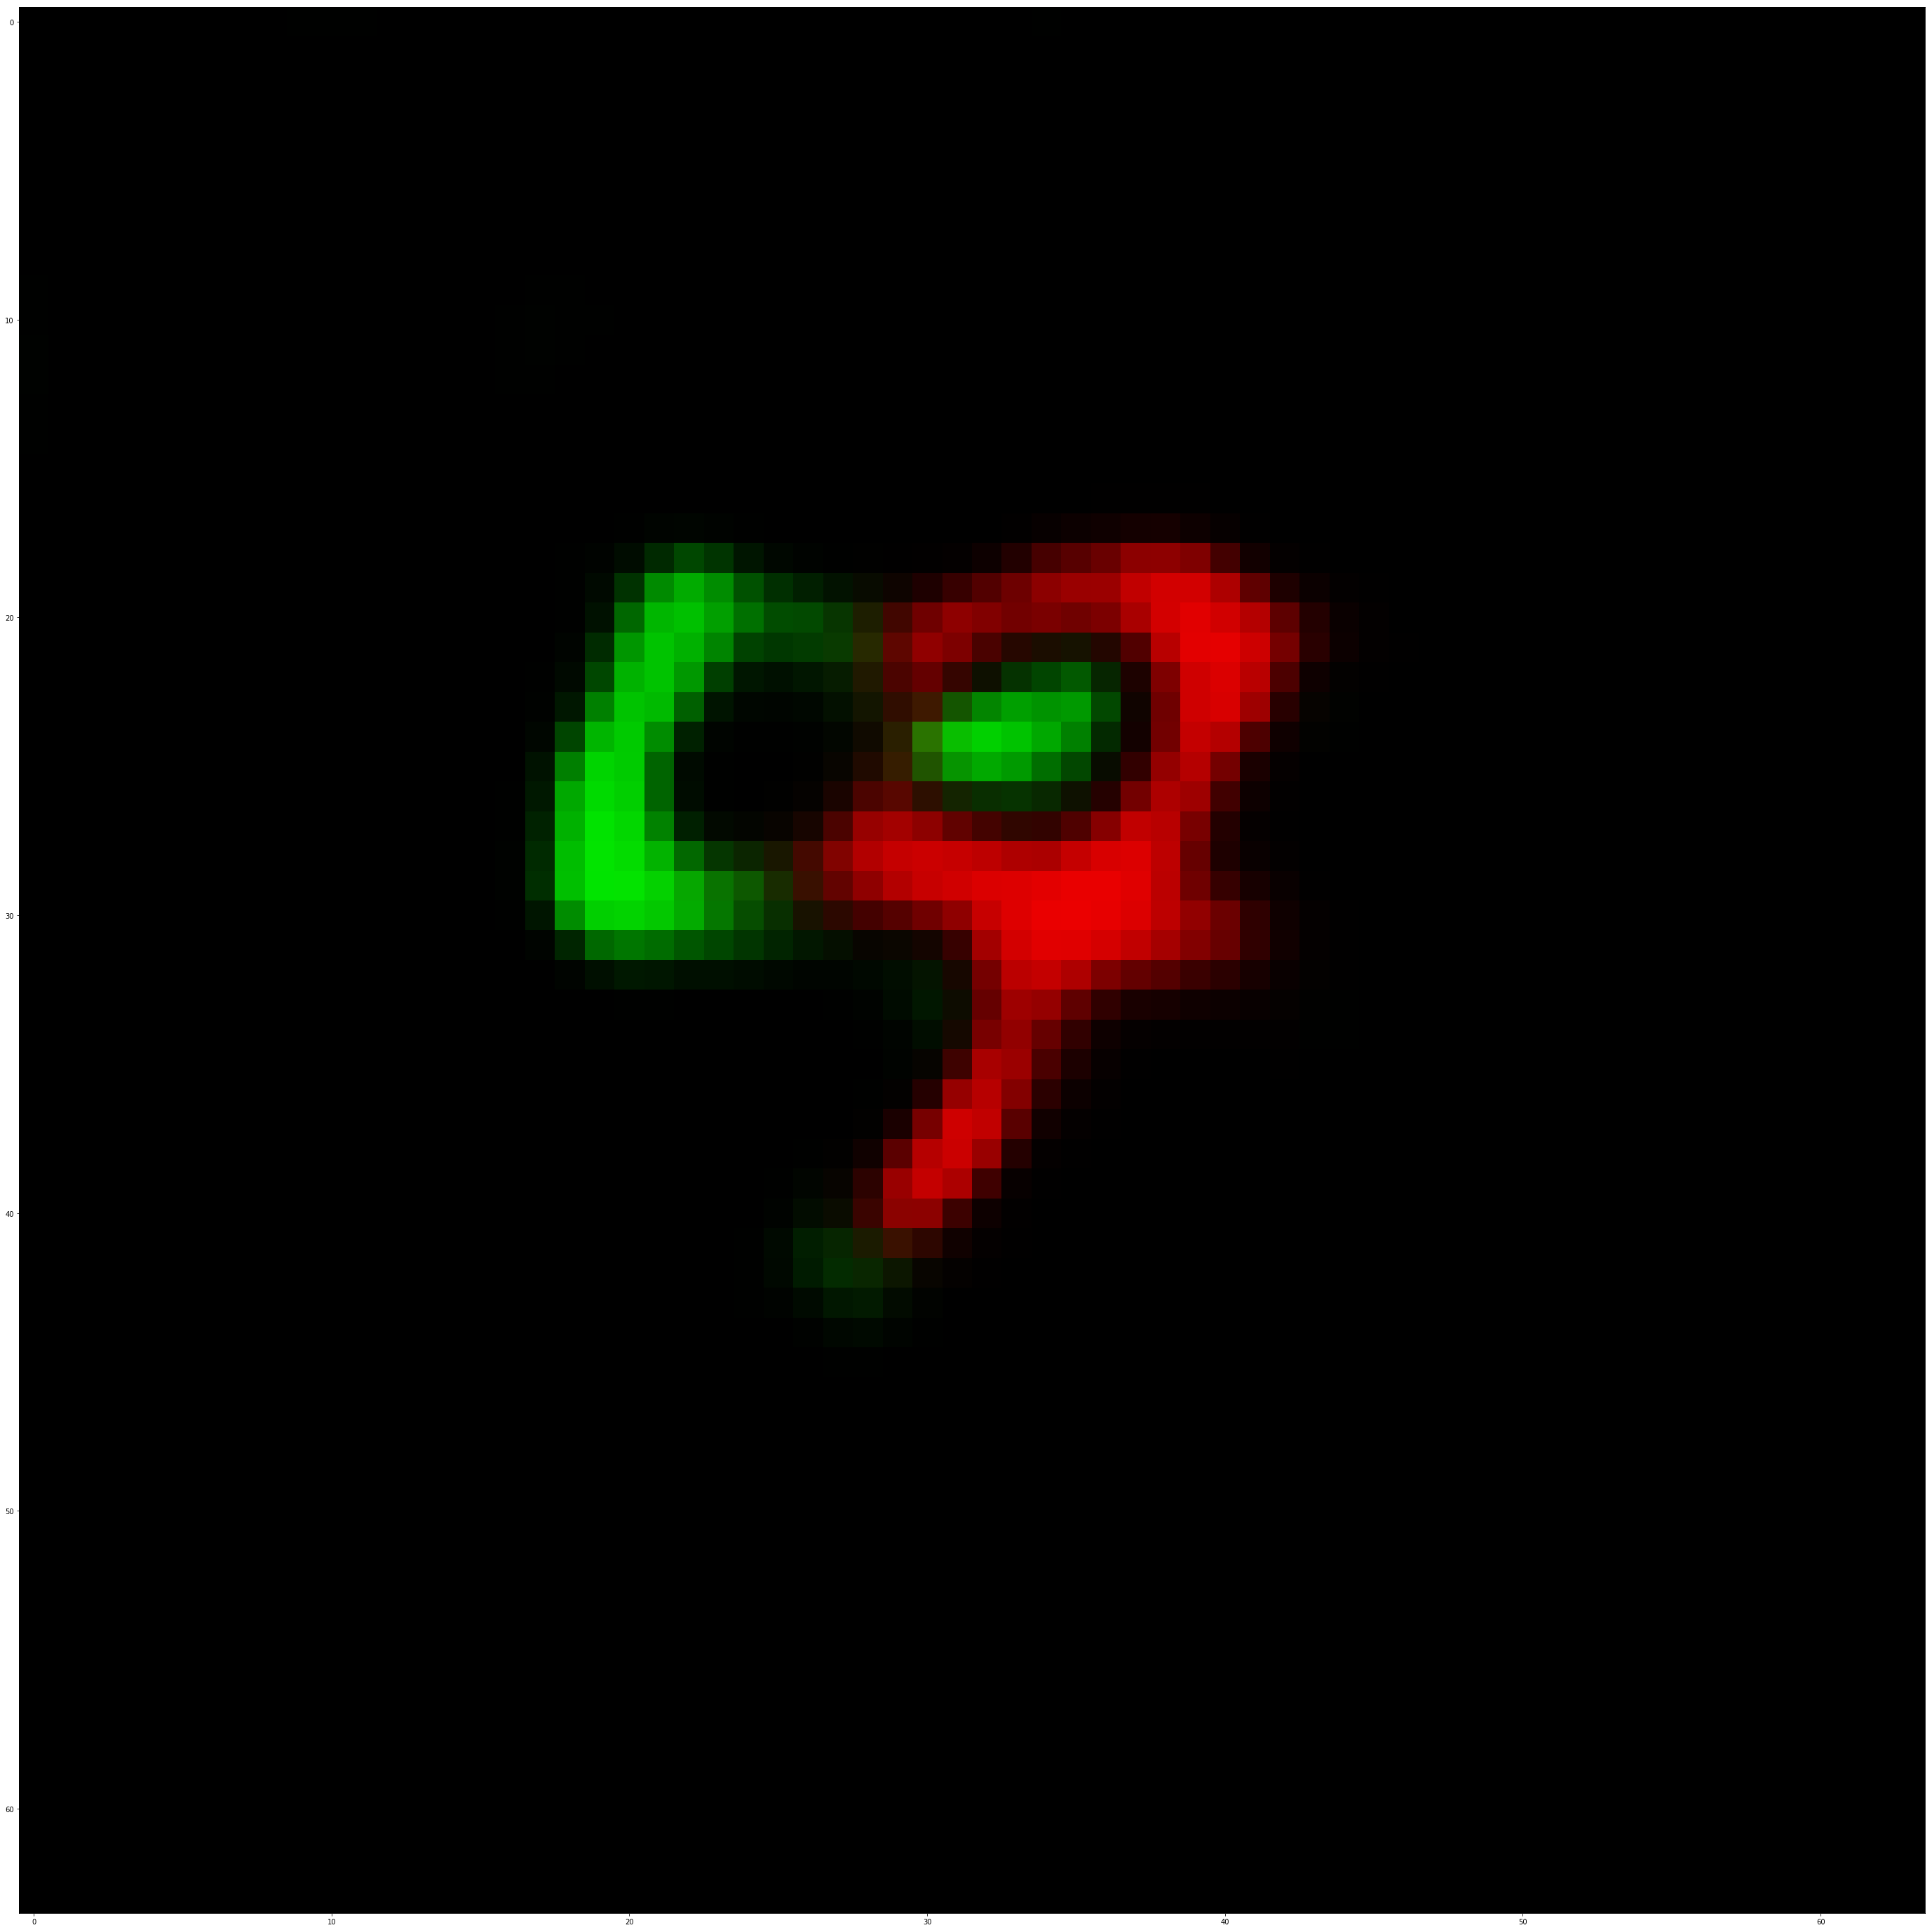

In [109]:
tf.reset_default_graph()    

#model = autoencoder_dense(learning_rate=0.1, weight_decay=0.000)    
model = autoencoder_conv(learning_rate=0.001, weight_decay=0.000)
#model = autoencoder_conv2(learning_rate=40, weight_decay=0.000)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    
    start = time.time()
    
    my_run_model(sess, model, epochs=1, batch_size=5 ,is_training=True, n_seq=1000,valset_check=True,is_save=True) # autoencoder_conv(learning_rate=40, weight_decay=0.000)  
    #my_run_model(sess, model, epochs=500, batch_size=100 ,is_training=True, n_seq=1000)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./save_model/model.ckpt
epoch : 1   , loss:0.0022, mae: 0.0076, 0.00% of epoch
epoch : 1   , loss:0.0021, mae: 0.0074, 8.33% of epoch
epoch : 1   , loss:0.0021, mae: 0.0075, 16.67% of epoch
epoch : 1   , loss:0.0020, mae: 0.0073, 25.00% of epoch
epoch : 1   , loss:0.0018, mae: 0.0068, 33.33% of epoch
epoch : 1   , loss:0.0019, mae: 0.0071, 41.67% of epoch
epoch : 1   , loss:0.0017, mae: 0.0065, 50.00% of epoch
epoch : 1   , loss:0.0018, mae: 0.0067, 58.33% of epoch
epoch : 1   , loss:0.0017, mae: 0.0064, 66.67% of epoch
epoch : 1   , loss:0.0017, mae: 0.0066, 75.00% of epoch
epoch : 1   , loss:0.0017, mae: 0.0065, 83.33% of epoch
epoch : 1   , loss:0.0016, mae: 0.0063, 91.67% of epoch
epoch end! --- epoch : 1   , loss:0.0019, mae: 0.0069 ***********
ru

INFO:tensorflow:Restoring parameters from ./save_model/model.ckpt
epoch : 1   , loss:0.0008, mae: 0.0041, 0.00% of epoch
epoch : 1   , loss:0.0010, mae: 0.0046, 8.33% of epoch
epoch : 1   , loss:0.0009, mae: 0.0043, 16.67% of epoch
epoch : 1   , loss:0.0010, mae: 0.0047, 25.00% of epoch
epoch : 1   , loss:0.0009, mae: 0.0045, 33.33% of epoch
epoch : 1   , loss:0.0008, mae: 0.0044, 41.67% of epoch
epoch : 1   , loss:0.0008, mae: 0.0041, 50.00% of epoch
epoch : 1   , loss:0.0008, mae: 0.0041, 58.33% of epoch
epoch : 1   , loss:0.0008, mae: 0.0041, 66.67% of epoch
epoch : 1   , loss:0.0008, mae: 0.0042, 75.00% of epoch
epoch : 1   , loss:0.0007, mae: 0.0040, 83.33% of epoch
epoch : 1   , loss:0.0007, mae: 0.0040, 91.67% of epoch
epoch end! --- epoch : 1   , loss:0.0009, mae: 0.0044 ***********
running time 26.157390594482422
epoch : 2   , loss:0.0008, mae: 0.0042, 0.00% of epoch
epoch : 2   , loss:0.0007, mae: 0.0039, 8.33% of epoch
epoch : 2   , loss:0.0007, mae: 0.0039, 16.67% of epoch


epoch : 1   , loss:0.0007, mae: 0.0038, 25.00% of epoch
epoch : 1   , loss:0.0007, mae: 0.0040, 33.33% of epoch
epoch : 1   , loss:0.0007, mae: 0.0039, 41.67% of epoch
epoch : 1   , loss:0.0006, mae: 0.0036, 50.00% of epoch
epoch : 1   , loss:0.0007, mae: 0.0039, 58.33% of epoch
epoch : 1   , loss:0.0006, mae: 0.0035, 66.67% of epoch
epoch : 1   , loss:0.0006, mae: 0.0035, 75.00% of epoch
epoch : 1   , loss:0.0006, mae: 0.0038, 83.33% of epoch
epoch : 1   , loss:0.0006, mae: 0.0035, 91.67% of epoch
epoch end! --- epoch : 1   , loss:0.0007, mae: 0.0039 ***********
running time 26.17108392715454
epoch : 2   , loss:0.0006, mae: 0.0036, 0.00% of epoch
epoch : 2   , loss:0.0006, mae: 0.0038, 8.33% of epoch
epoch : 2   , loss:0.0006, mae: 0.0035, 16.67% of epoch
epoch : 2   , loss:0.0006, mae: 0.0036, 25.00% of epoch
epoch : 2   , loss:0.0005, mae: 0.0034, 33.33% of epoch
epoch : 2   , loss:0.0006, mae: 0.0036, 41.67% of epoch
epoch : 2   , loss:0.0006, mae: 0.0035, 50.00% of epoch
epoch : 2

epoch : 1   , loss:0.0006, mae: 0.0035, 58.33% of epoch
epoch : 1   , loss:0.0005, mae: 0.0034, 66.67% of epoch
epoch : 1   , loss:0.0005, mae: 0.0033, 75.00% of epoch
epoch : 1   , loss:0.0005, mae: 0.0033, 83.33% of epoch
epoch : 1   , loss:0.0005, mae: 0.0034, 91.67% of epoch
epoch end! --- epoch : 1   , loss:0.0006, mae: 0.0037 ***********
running time 26.021220922470093
epoch : 2   , loss:0.0005, mae: 0.0033, 0.00% of epoch
epoch : 2   , loss:0.0005, mae: 0.0033, 8.33% of epoch
epoch : 2   , loss:0.0005, mae: 0.0033, 16.67% of epoch
epoch : 2   , loss:0.0005, mae: 0.0033, 25.00% of epoch
epoch : 2   , loss:0.0005, mae: 0.0032, 33.33% of epoch
epoch : 2   , loss:0.0005, mae: 0.0033, 41.67% of epoch
epoch : 2   , loss:0.0005, mae: 0.0033, 50.00% of epoch
epoch : 2   , loss:0.0005, mae: 0.0033, 58.33% of epoch
epoch : 2   , loss:0.0005, mae: 0.0031, 66.67% of epoch
epoch : 2   , loss:0.0005, mae: 0.0032, 75.00% of epoch
epoch : 2   , loss:0.0005, mae: 0.0032, 83.33% of epoch
epoch : 

epoch : 1   , loss:0.0004, mae: 0.0030, 91.67% of epoch
epoch end! --- epoch : 1   , loss:0.0006, mae: 0.0035 ***********
running time 26.175548315048218
epoch : 2   , loss:0.0005, mae: 0.0032, 0.00% of epoch
epoch : 2   , loss:0.0004, mae: 0.0031, 8.33% of epoch
epoch : 2   , loss:0.0005, mae: 0.0031, 16.67% of epoch
epoch : 2   , loss:0.0004, mae: 0.0031, 25.00% of epoch
epoch : 2   , loss:0.0004, mae: 0.0031, 33.33% of epoch
epoch : 2   , loss:0.0005, mae: 0.0031, 41.67% of epoch
epoch : 2   , loss:0.0004, mae: 0.0030, 50.00% of epoch
epoch : 2   , loss:0.0004, mae: 0.0031, 58.33% of epoch
epoch : 2   , loss:0.0004, mae: 0.0029, 66.67% of epoch
epoch : 2   , loss:0.0004, mae: 0.0031, 75.00% of epoch
epoch : 2   , loss:0.0004, mae: 0.0030, 83.33% of epoch
epoch : 2   , loss:0.0004, mae: 0.0031, 91.67% of epoch
epoch end! --- epoch : 2   , loss:0.0004, mae: 0.0031 ***********
running time 51.568981647491455
epoch : 3   , loss:0.0004, mae: 0.0030, 0.00% of epoch
epoch : 3   , loss:0.00

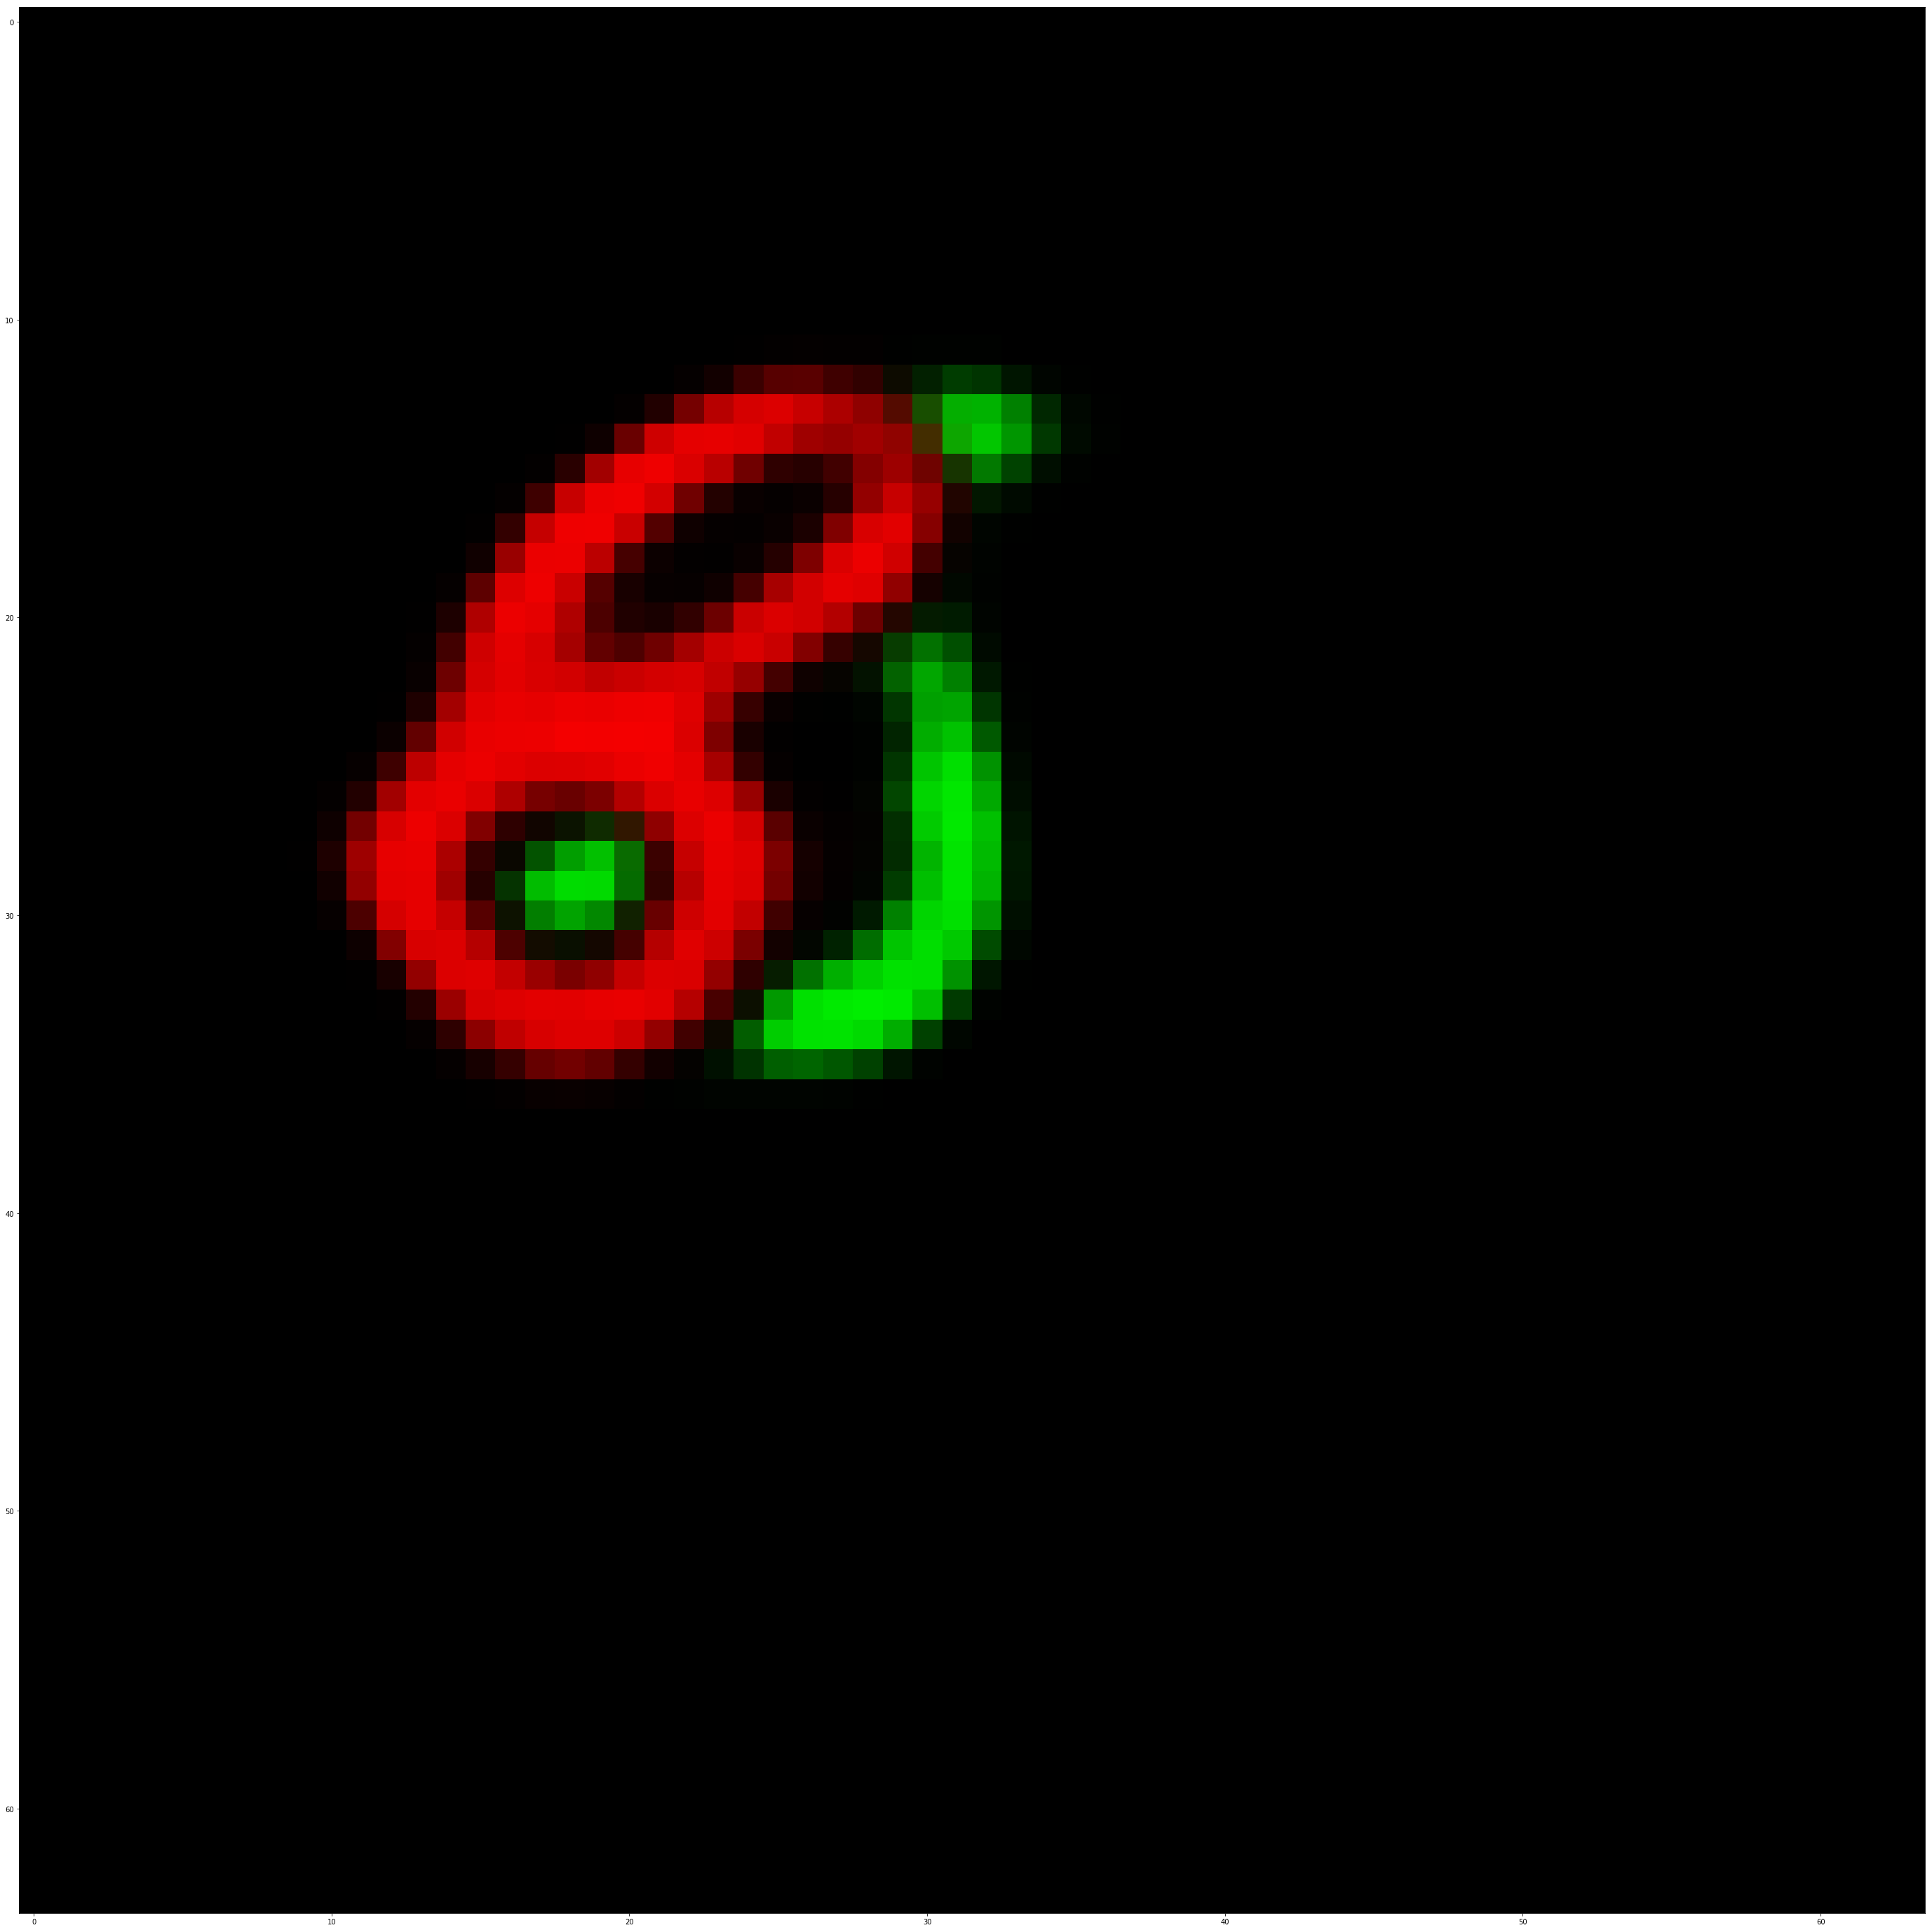

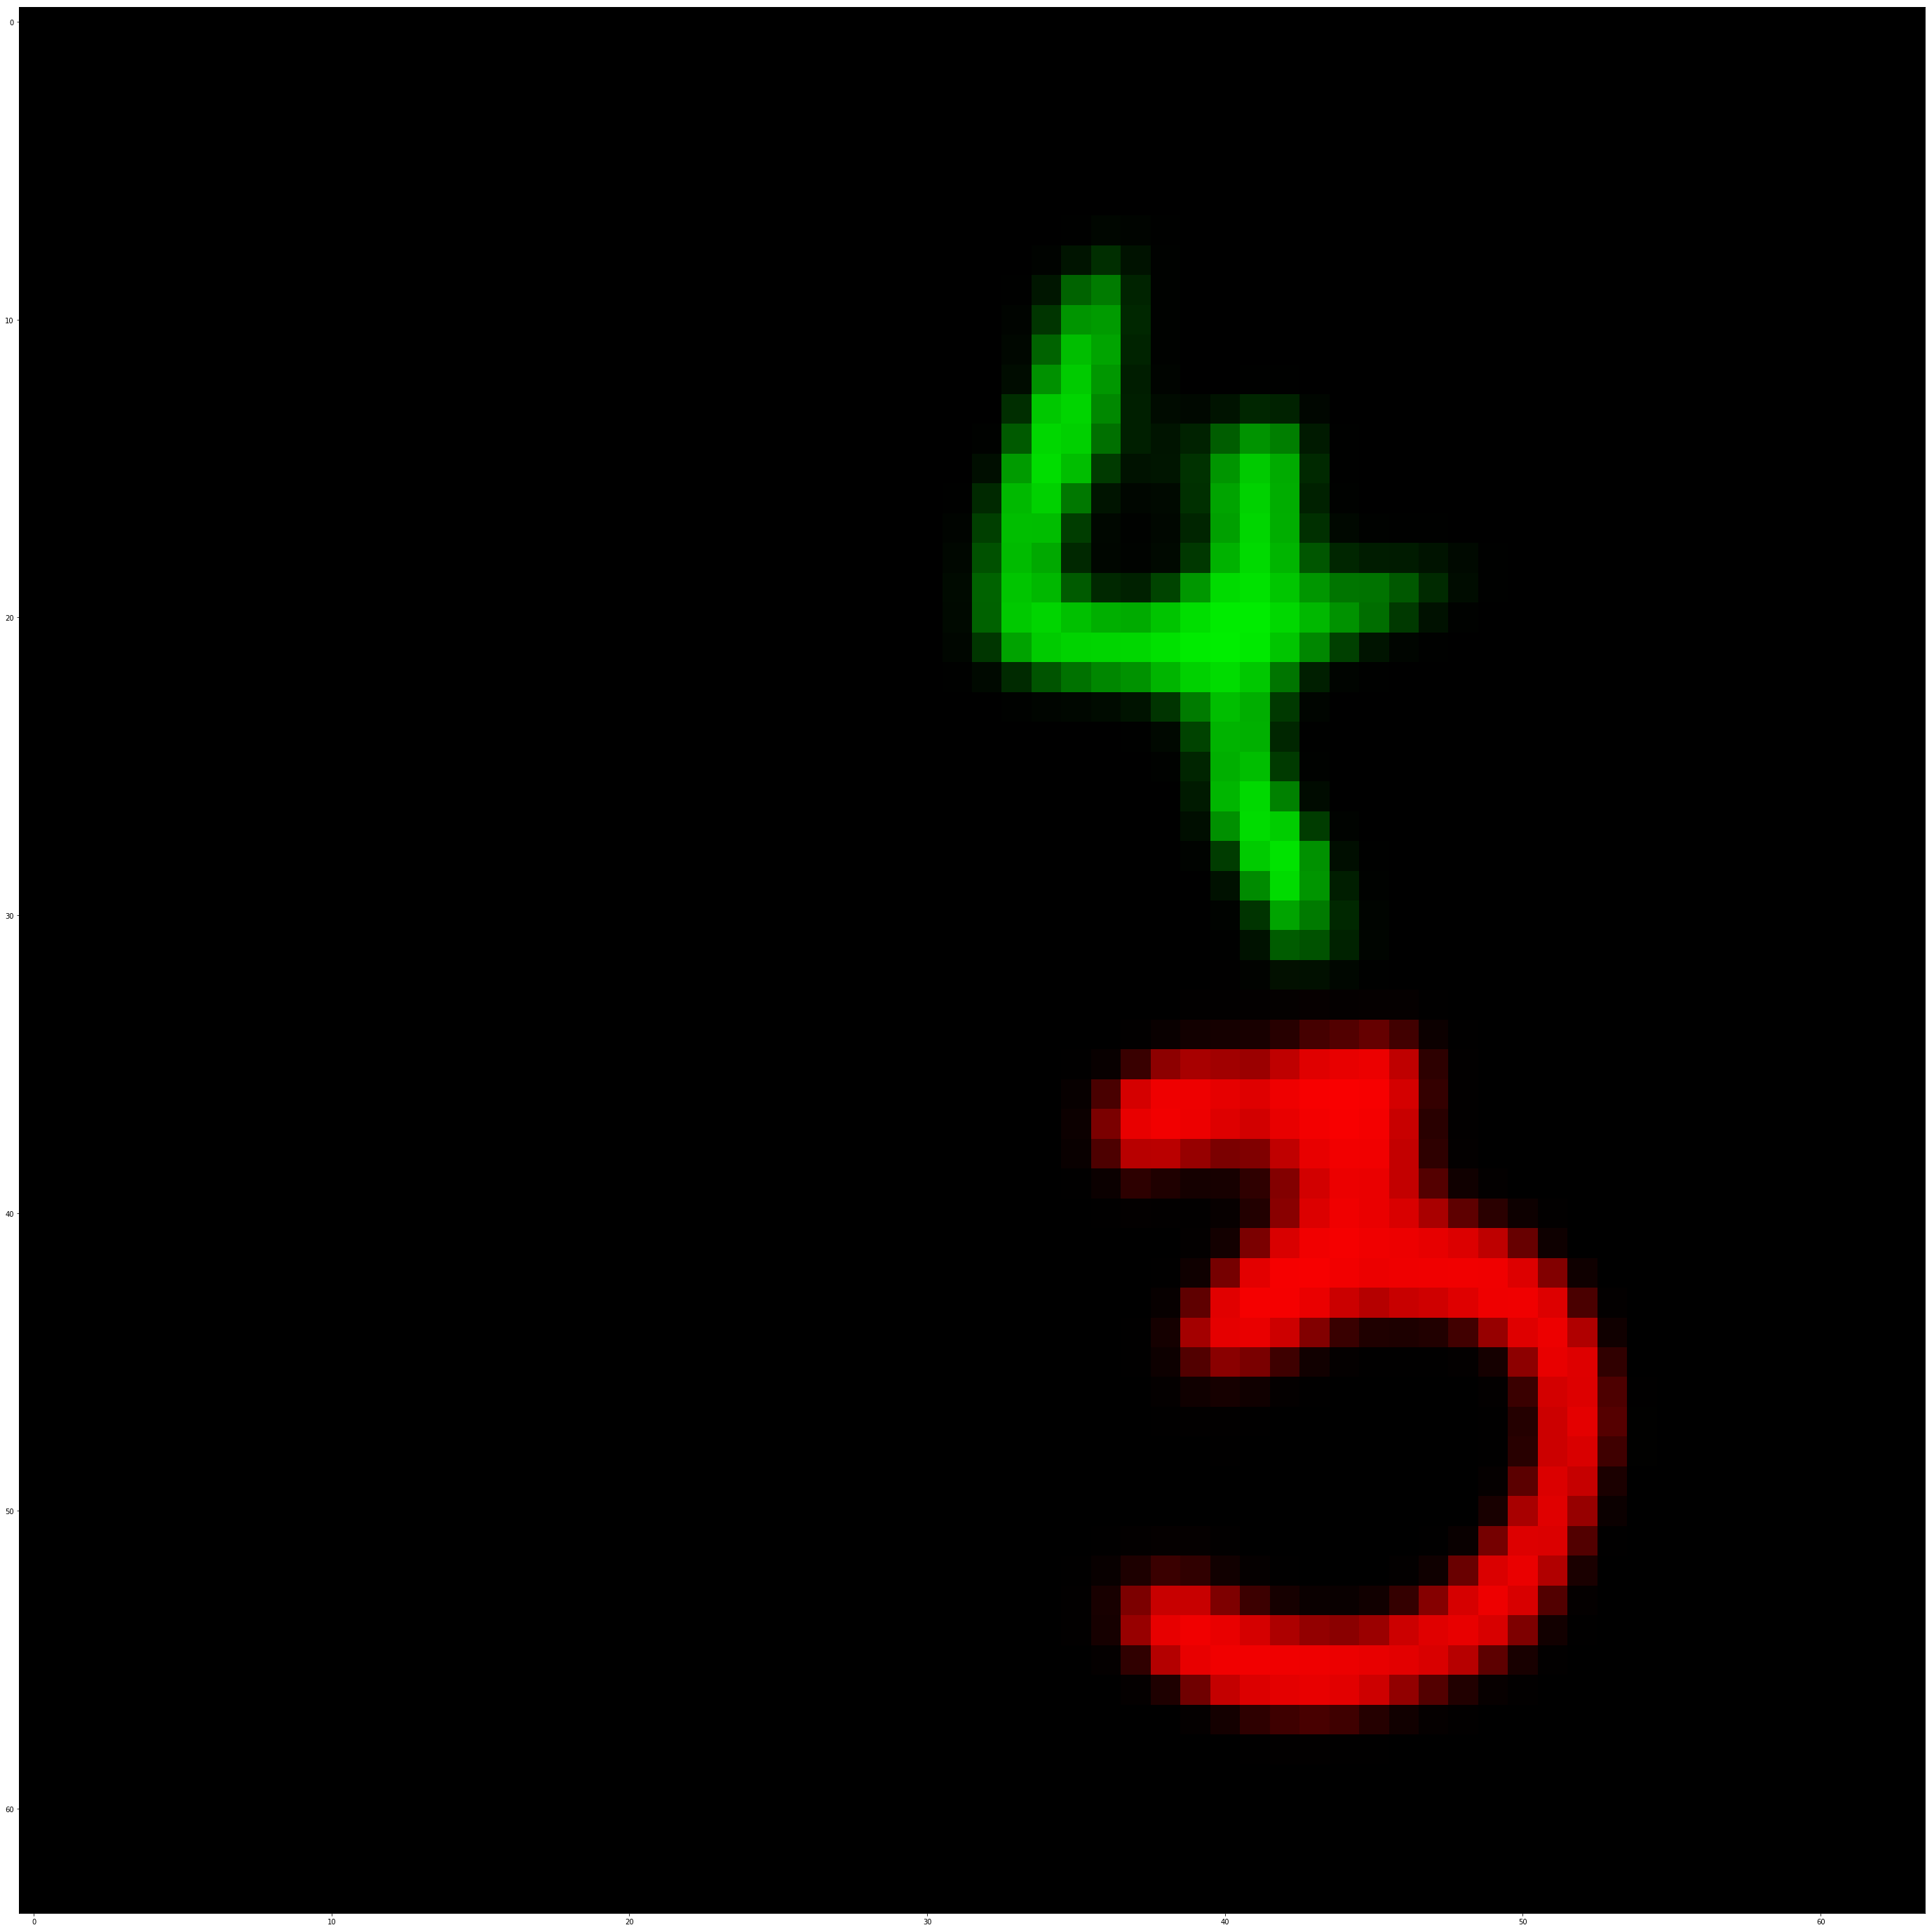

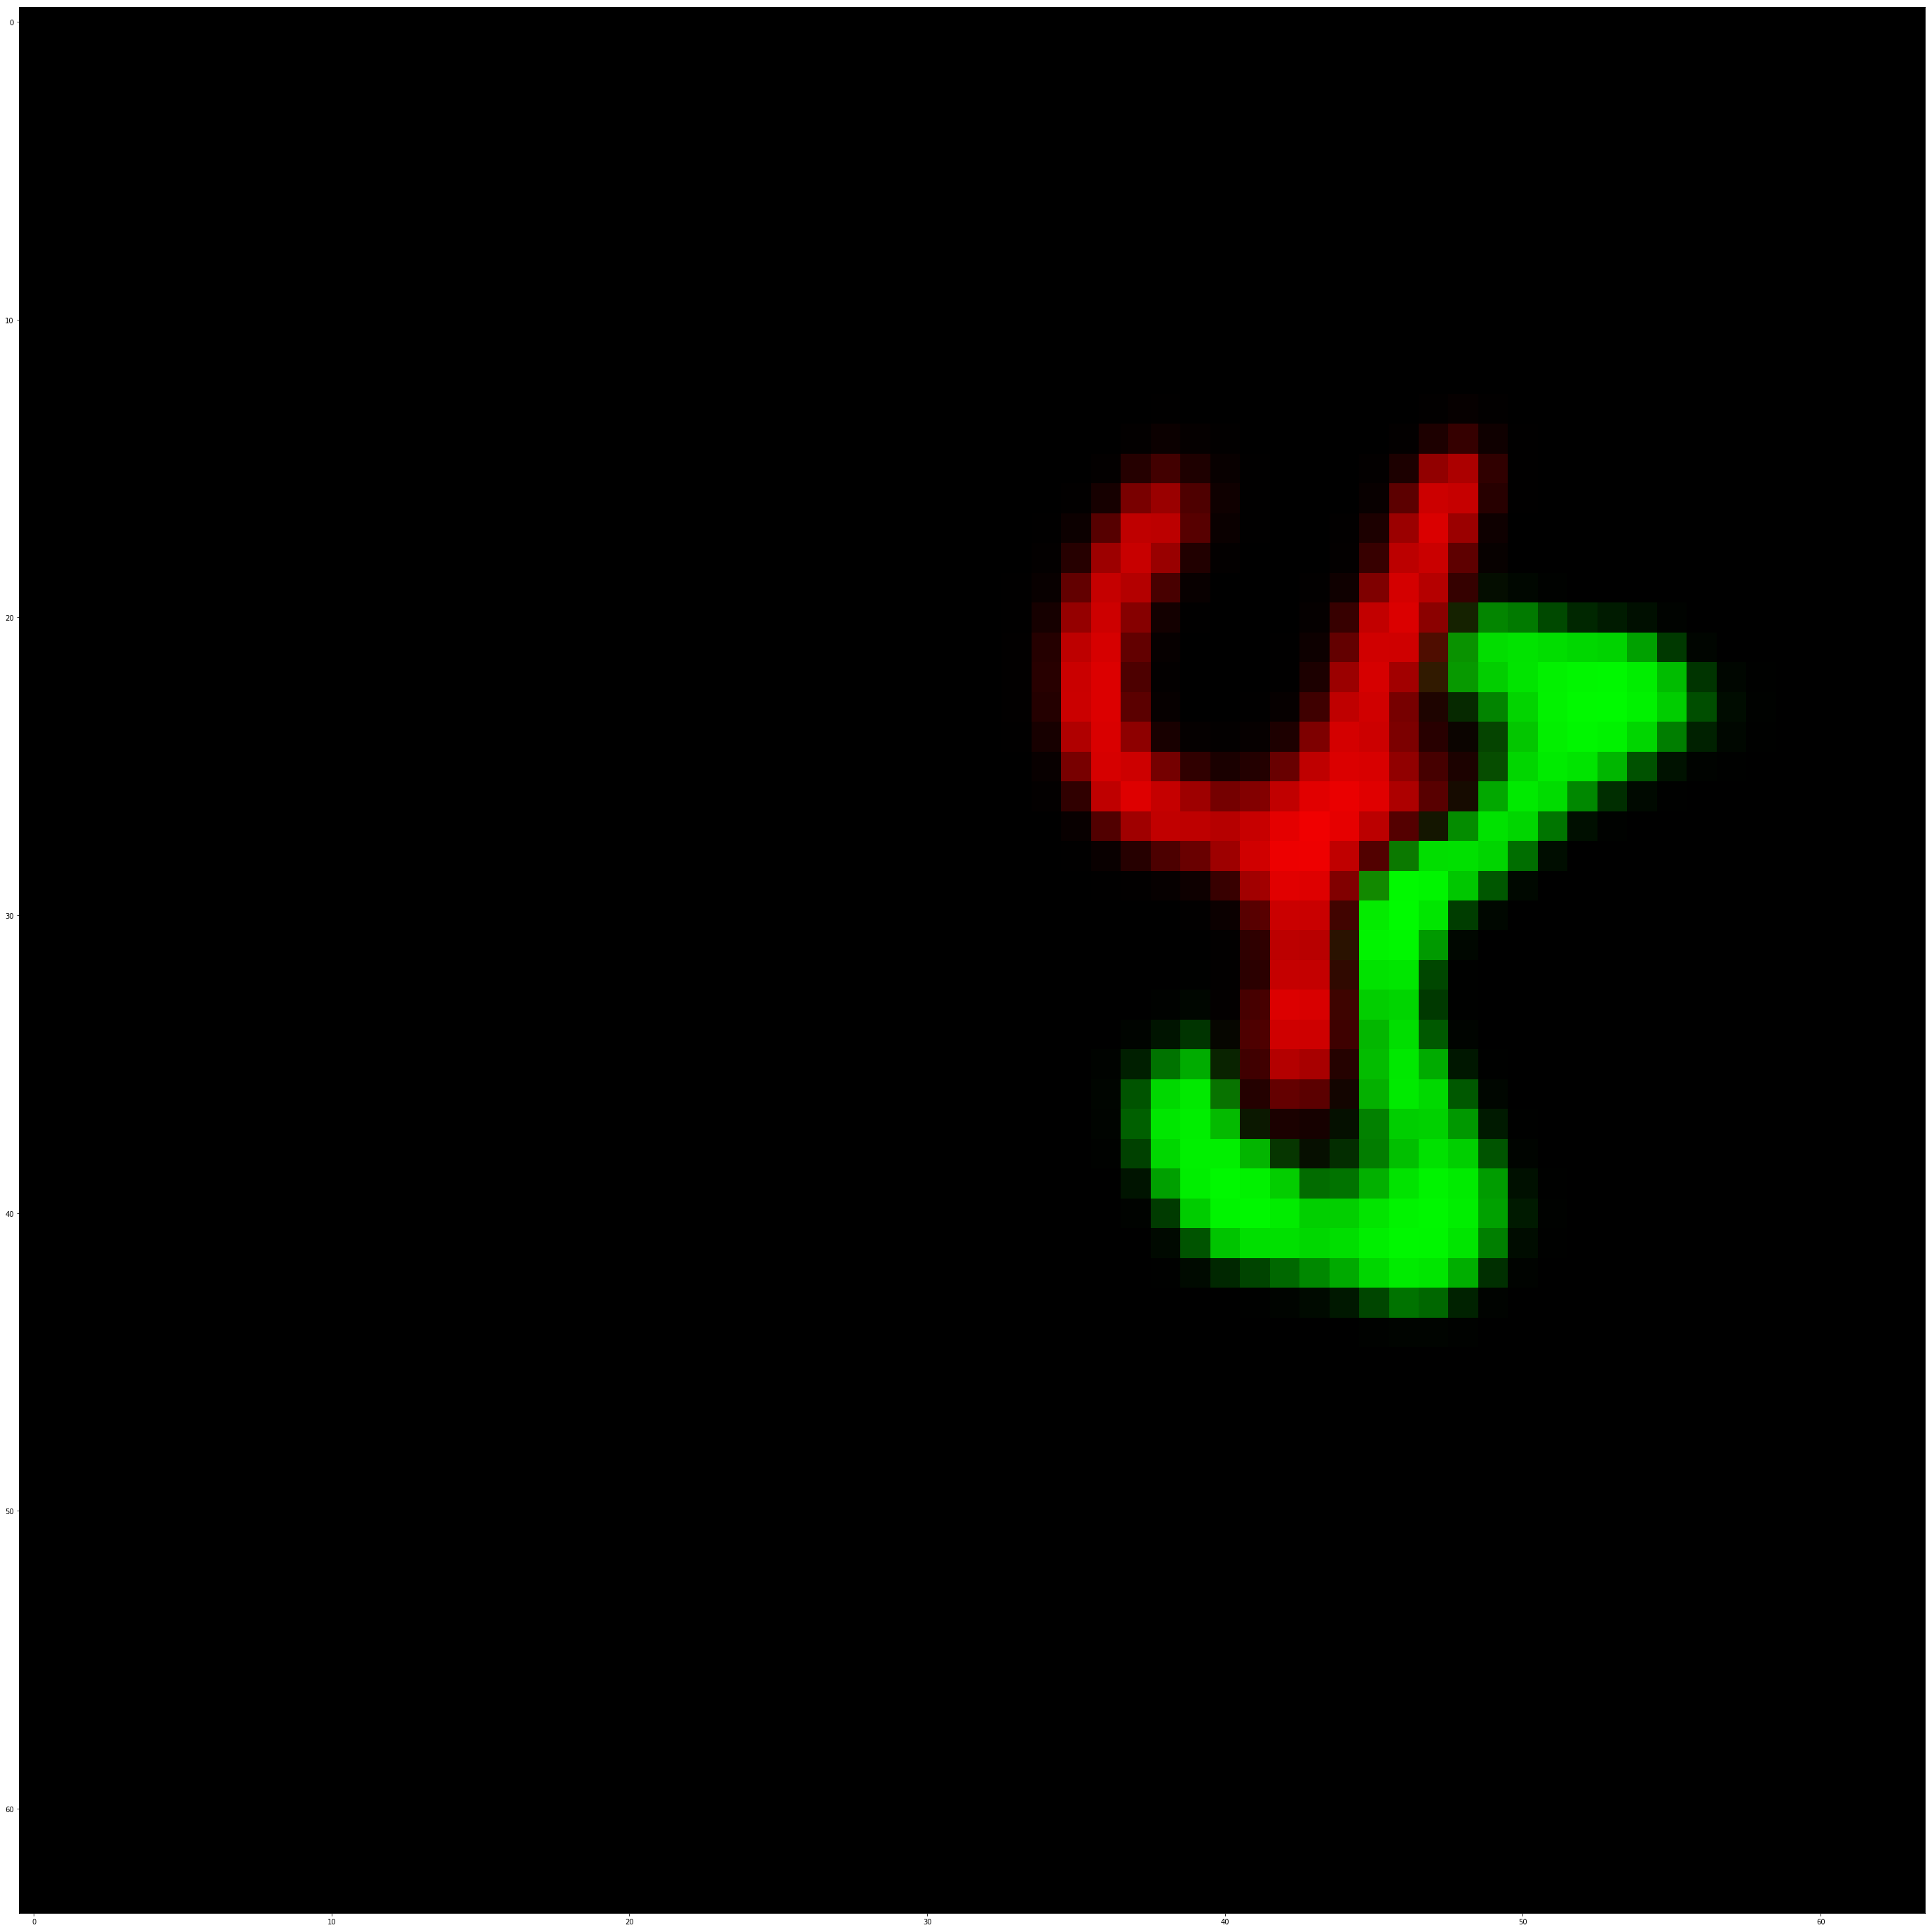

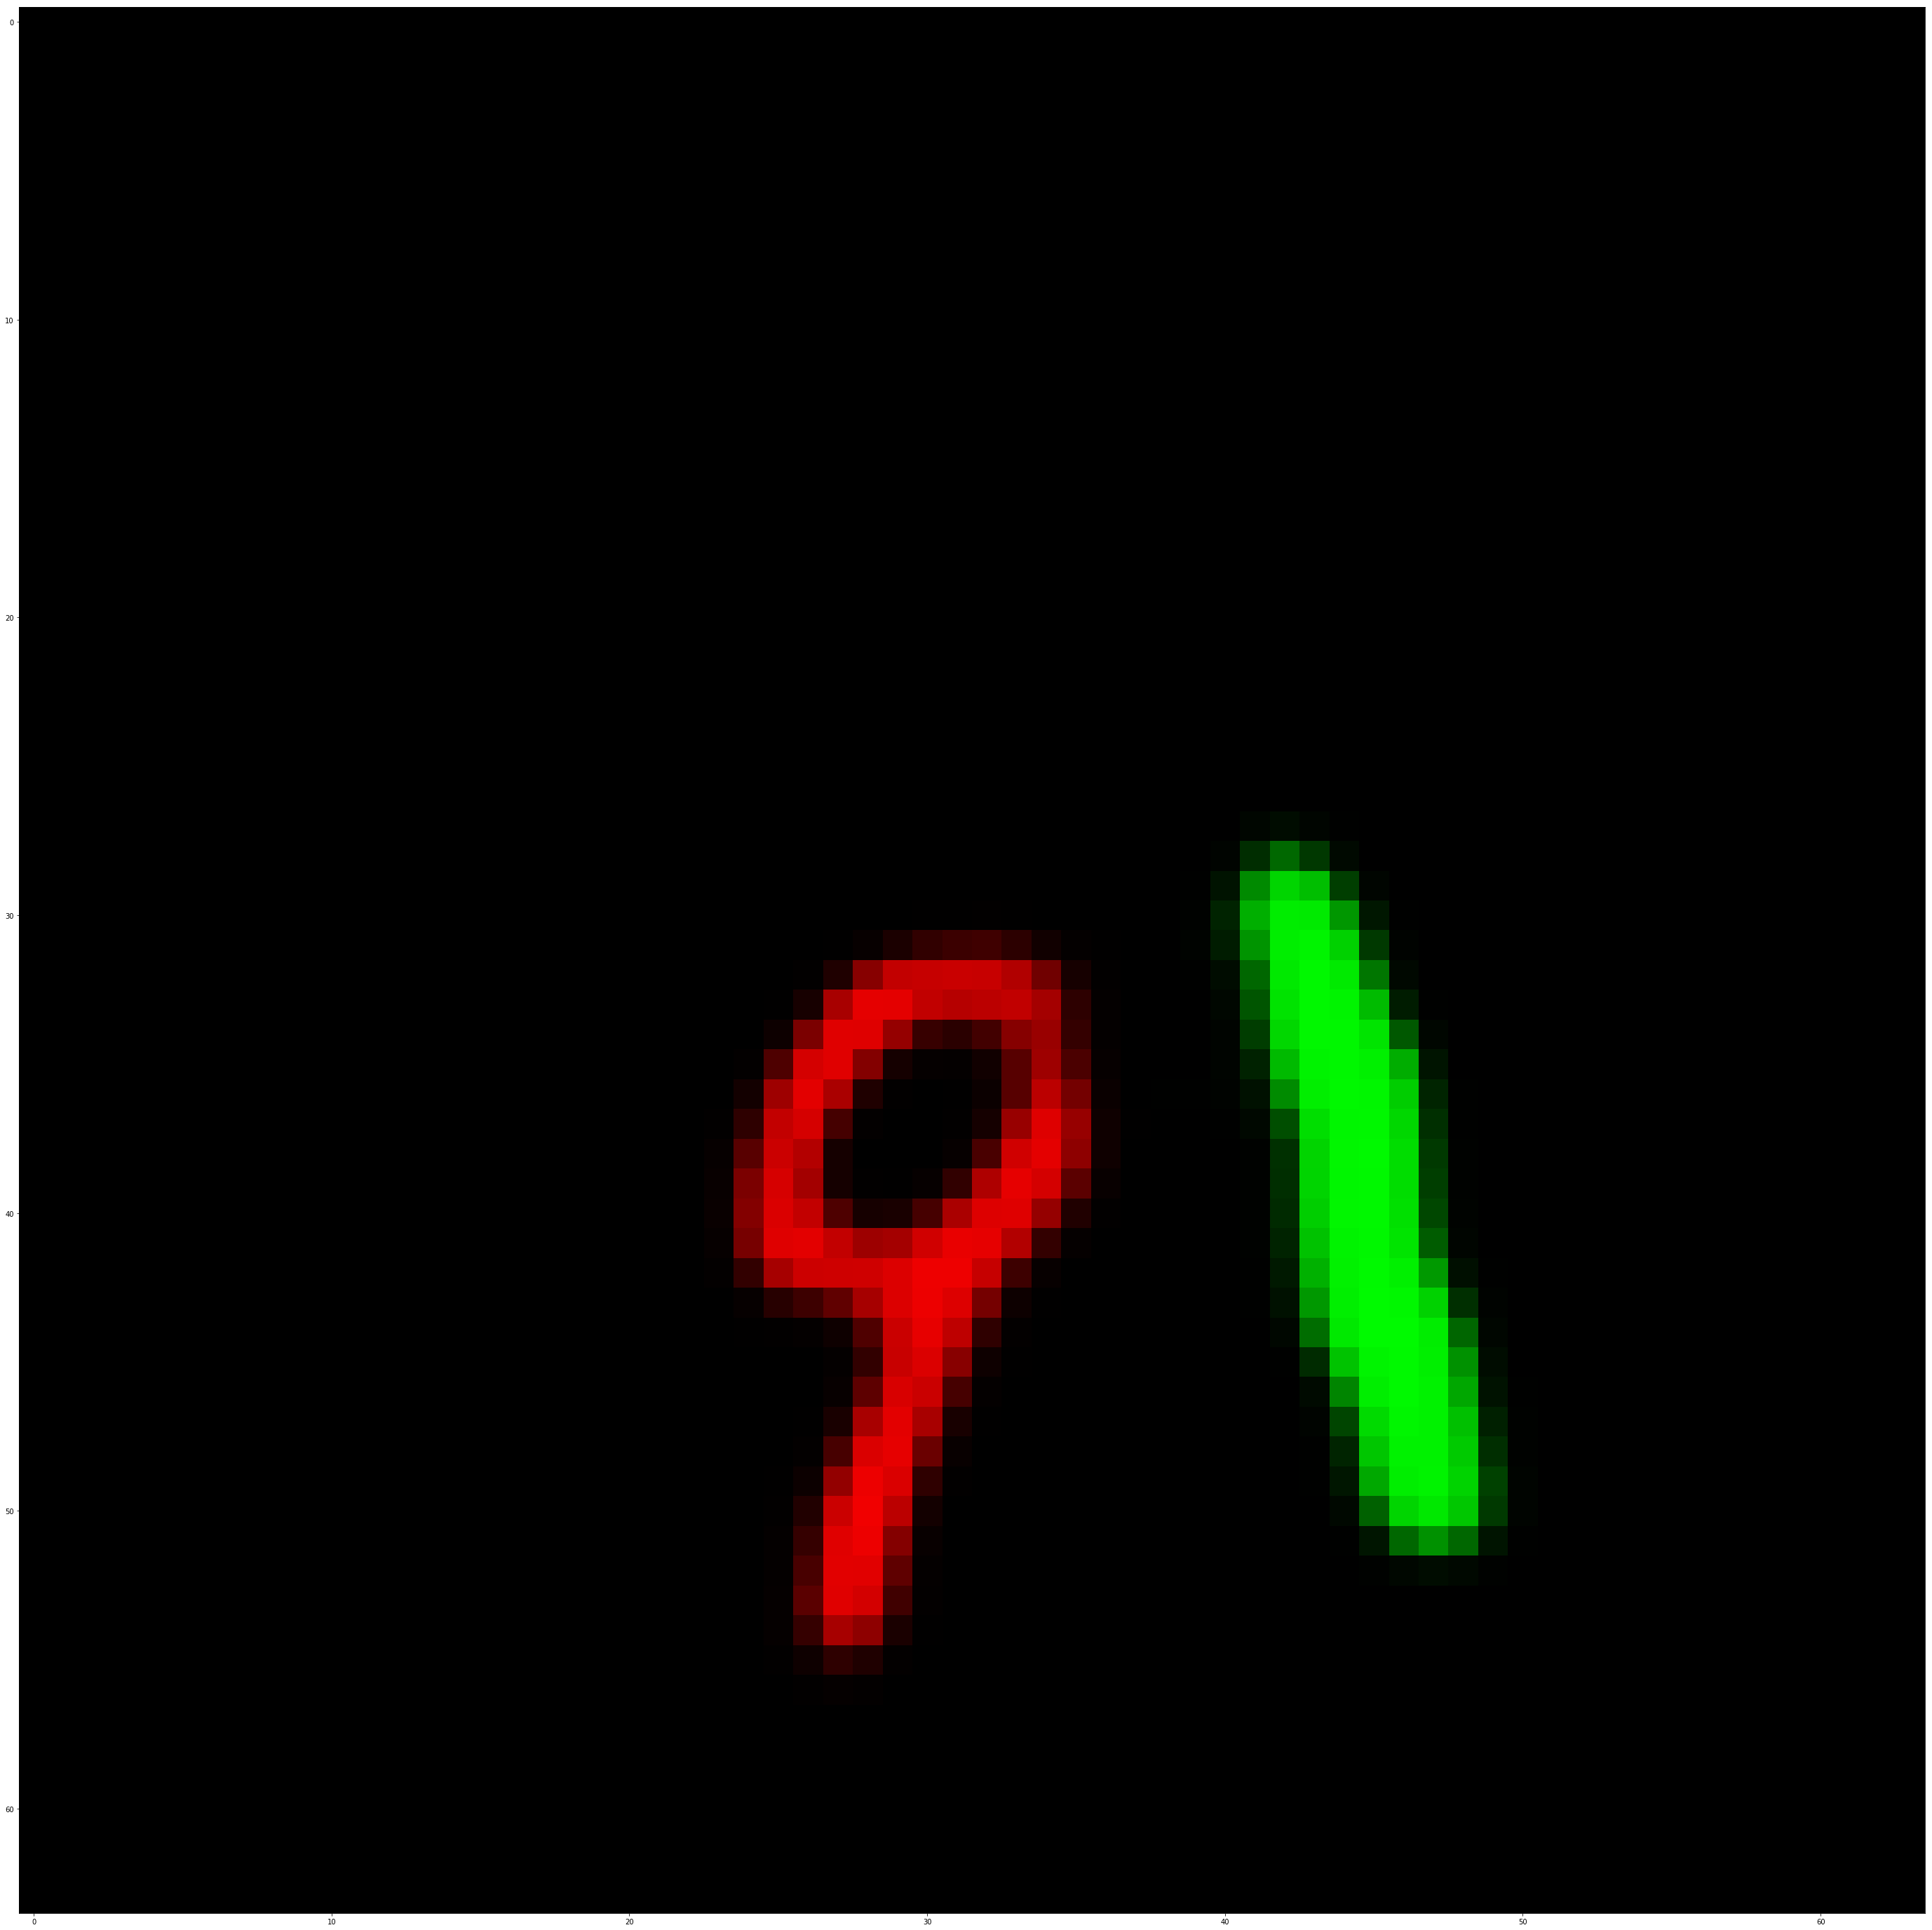

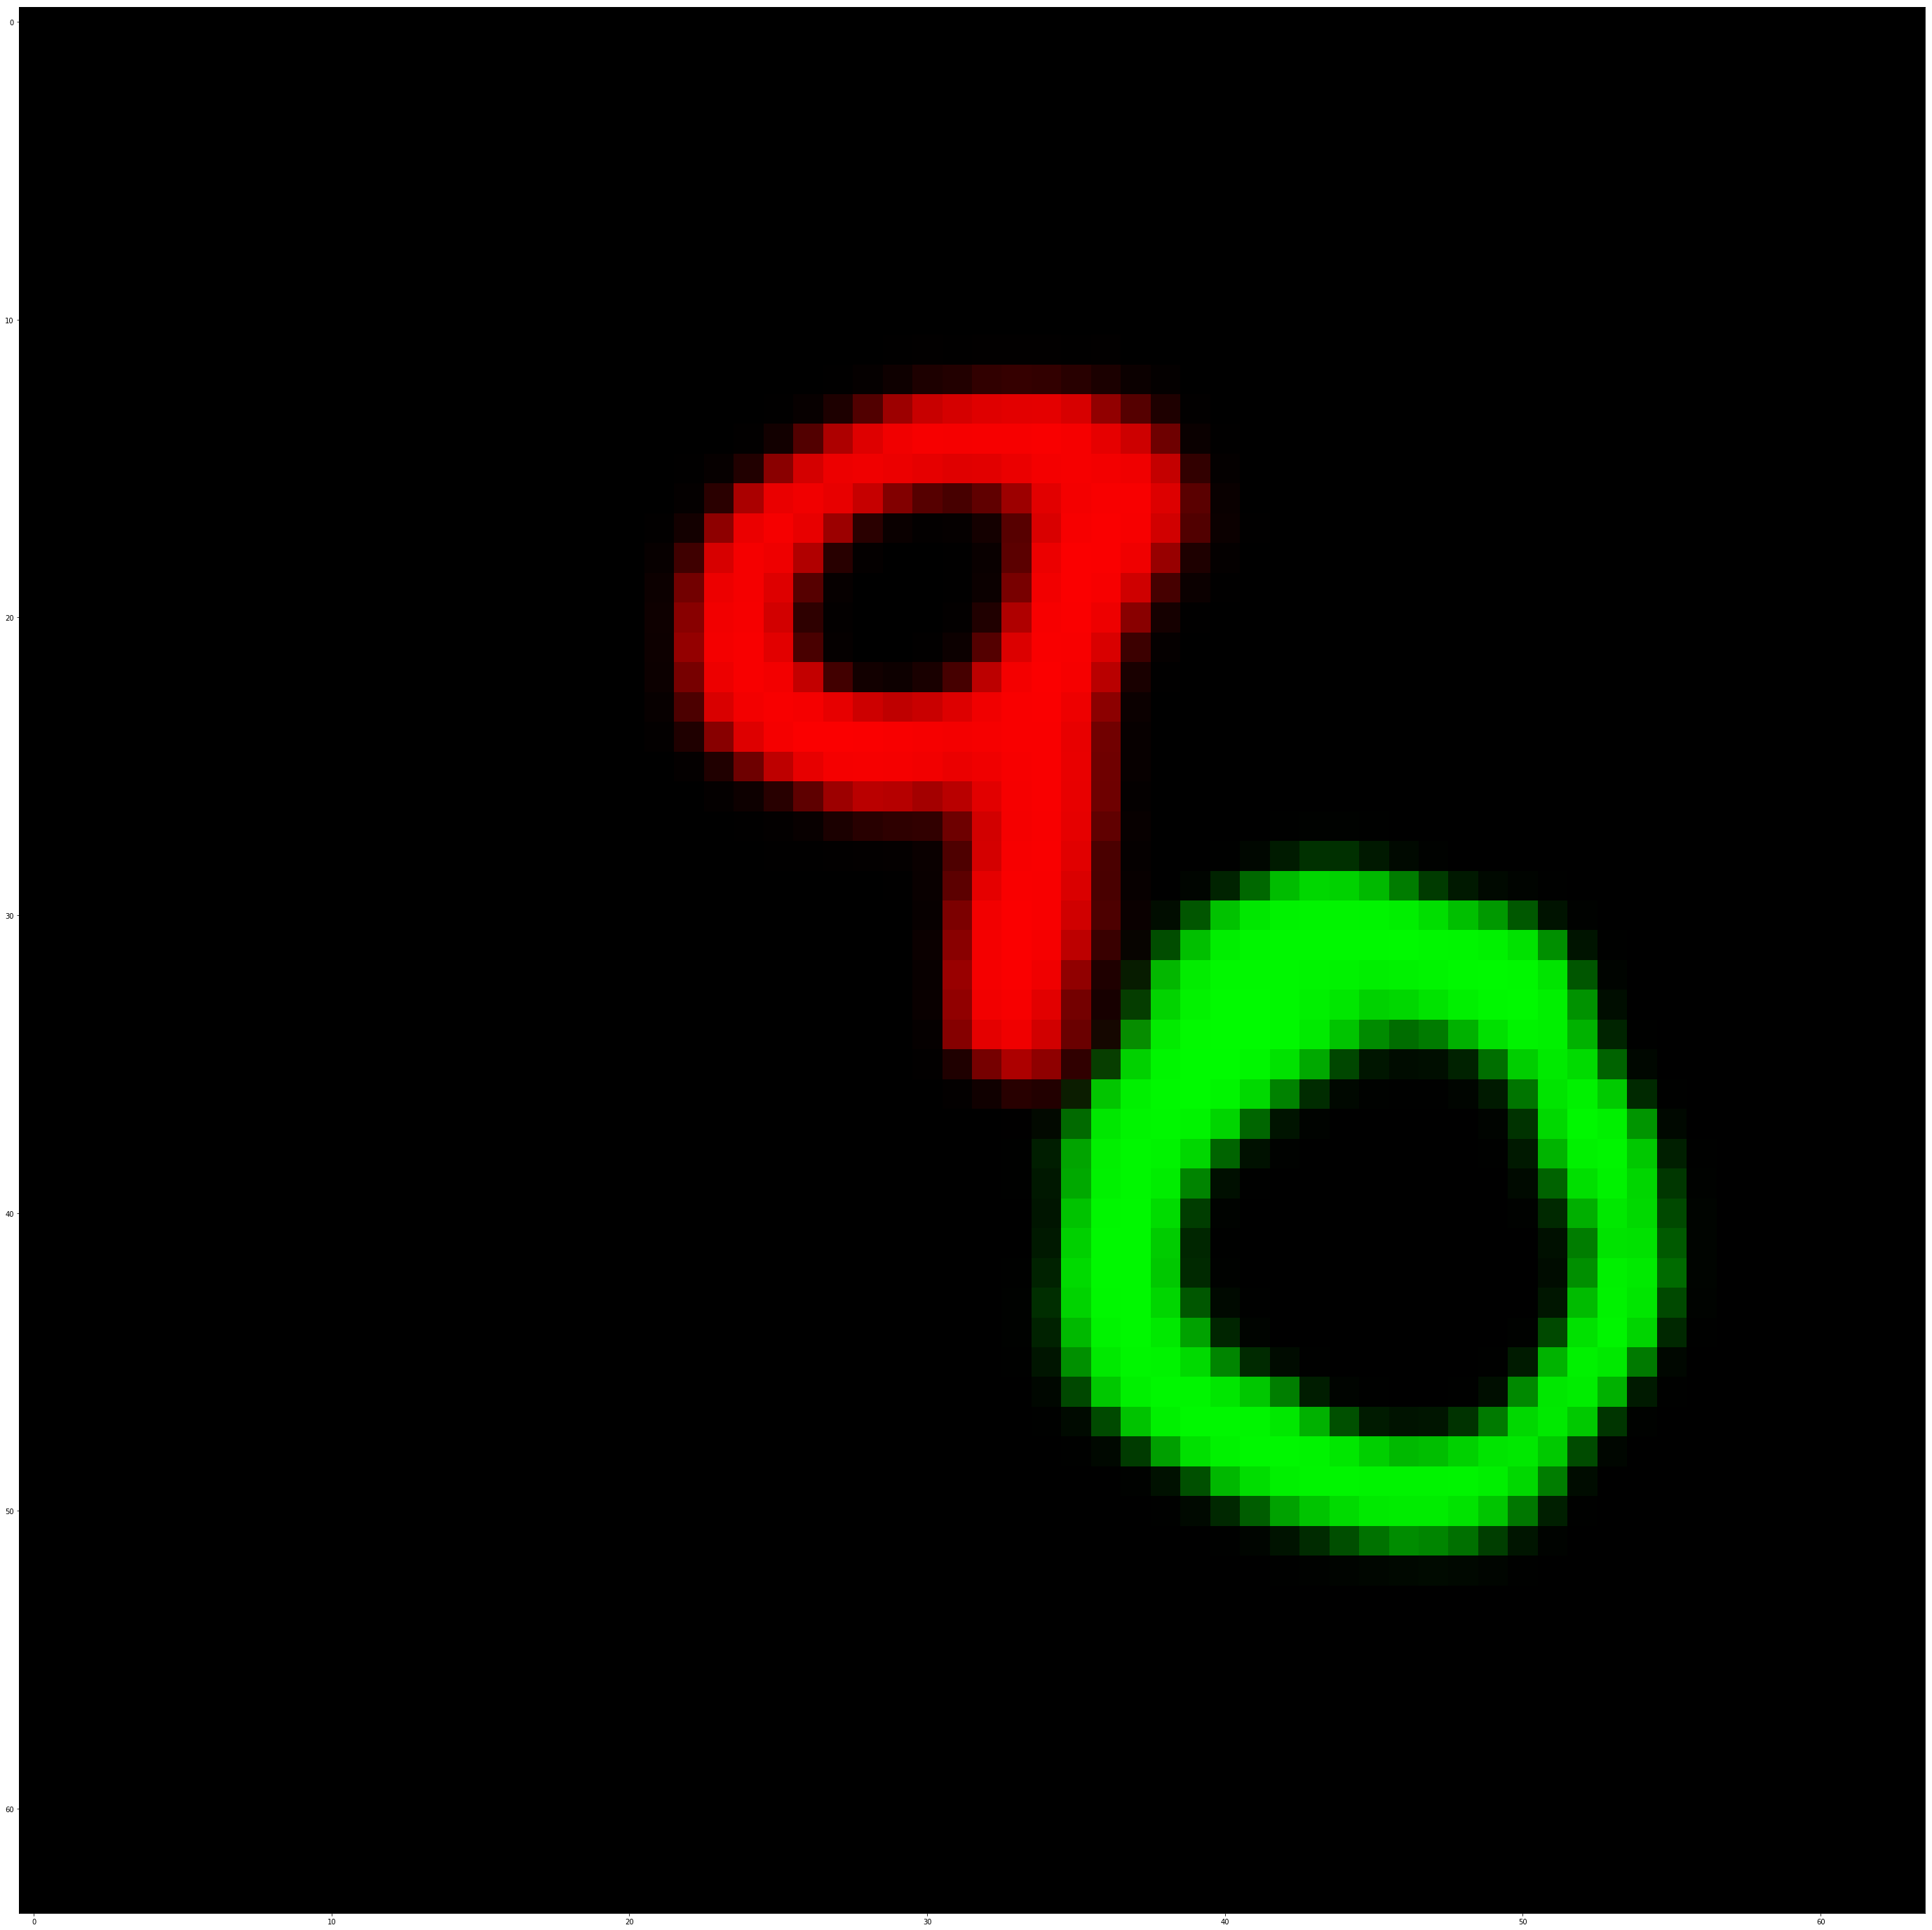

In [110]:
for i in range(5):
    tf.reset_default_graph()    

    model = autoencoder_conv(learning_rate=0.001, weight_decay=0.000)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        start = time.time()

        my_run_model(sess, model, epochs=10, batch_size=50 ,is_training=True, n_seq=3000,valset_check=True) # autoencoder_conv(learning_rate=40, weight_decay=0.000)  


In [231]:
from tensorflow.python.tools import inspect_checkpoint as chkp

# print all tensors in checkpoint file
chkp.print_tensors_in_checkpoint_file("./save_model_lstm/model.ckpt", tensor_name='', all_tensors=True)


tensor_name:  Variable
[[ 3.9741151e-02  1.3066298e-01  1.3288708e-01 ...  3.0780951e-02
   2.3863910e-01 -1.4009812e-01]
 [-8.8714615e-02  6.3915388e-03 -4.5826066e-02 ...  1.8522708e-02
   1.5417255e-01  1.8643548e-01]
 [ 1.7208315e-01  1.8819585e-01  2.1092923e-02 ...  3.4033831e-02
   5.3231064e-03  6.8809022e-05]
 ...
 [-3.8892340e-02  2.0747843e-01  2.9423538e-01 ...  5.6180716e-02
   2.8261131e-01 -1.6384074e-01]
 [-1.2331481e-01  8.1056185e-02 -2.7247921e-01 ... -2.0488879e-01
  -6.5449430e-03 -1.1059781e-02]
 [-1.8661663e-01 -1.3128574e-01  1.4467576e-01 ...  5.3895857e-02
   3.6834236e-02  4.5567779e-03]]
tensor_name:  Variable/Adam
[[ 4.07662348e-08 -1.93065532e-07 -1.54730877e-08 ...  1.69924348e-07
  -5.56206743e-08  4.78995581e-08]
 [ 1.01765366e-07  3.32949099e-08 -2.81489150e-07 ...  1.55862608e-07
   3.46925688e-08  1.40988178e-07]
 [-2.16178123e-07  1.04648954e-07  2.45525371e-07 ...  4.32740777e-08
   2.51424922e-07  3.06687298e-07]
 ...
 [ 5.60468045e-08  3.30437757

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./save_model/model.ckpt
epoch : 1   , loss:0.0139, mae: 0.0191 
epoch end! --- epoch : 1   , loss:0.0139, mae: 0.0191 ***********
running time 0.24376893043518066
epoch : 2   , loss:0.0154, mae: 0.0211 
epoch end! --- epoch : 2   , loss:0.0154, mae: 0.0211 ***********
running time 0.26732707023620605
epoch : 3   , loss:0.0140, mae: 0.0191 
epoch end! --- epoch : 3   , loss:0.0140, mae: 0.0191 ***********
running time 0.2977581024169922
epoch : 4   , loss:0.0163, mae: 0.0222 
epoch end! --- epoch : 4   , loss:0.0163, mae: 0.0222 ***********
running time 0.3293130397796631
epoch : 5   , loss:0.0139, mae: 0.0191 
epoch end! --- epoch : 5   , loss:0.0139, mae: 0.0191 ***********
running time 0.36175823211669

epoch : 63  , loss:0.0066, mae: 0.0149 
epoch end! --- epoch : 63  , loss:0.0066, mae: 0.0149 ***********
running time 2.2294540405273438
epoch : 64  , loss:0.0062, mae: 0.0141 
epoch end! --- epoch : 64  , loss:0.0062, mae: 0.0141 ***********
running time 2.2677547931671143
epoch : 65  , loss:0.0054, mae: 0.0135 
epoch end! --- epoch : 65  , loss:0.0054, mae: 0.0135 ***********
running time 2.3055615425109863
epoch : 66  , loss:0.0052, mae: 0.0132 
epoch end! --- epoch : 66  , loss:0.0052, mae: 0.0132 ***********
running time 2.343628168106079
epoch : 67  , loss:0.0071, mae: 0.0166 
epoch end! --- epoch : 67  , loss:0.0071, mae: 0.0166 ***********
running time 2.382193088531494
epoch : 68  , loss:0.0072, mae: 0.0163 
epoch end! --- epoch : 68  , loss:0.0072, mae: 0.0163 ***********
running time 2.420714855194092
epoch : 69  , loss:0.0075, mae: 0.0169 
epoch end! --- epoch : 69  , loss:0.0075, mae: 0.0169 ***********
running time 2.4606239795684814
epoch : 70  , loss:0.0067, mae: 0.016

epoch : 123 , loss:0.0030, mae: 0.0102 
epoch end! --- epoch : 123 , loss:0.0030, mae: 0.0102 ***********
running time 4.545404672622681
epoch : 124 , loss:0.0032, mae: 0.0107 
epoch end! --- epoch : 124 , loss:0.0032, mae: 0.0107 ***********
running time 4.583634376525879
epoch : 125 , loss:0.0036, mae: 0.0118 
epoch end! --- epoch : 125 , loss:0.0036, mae: 0.0118 ***********
running time 4.621018648147583
epoch : 126 , loss:0.0032, mae: 0.0107 
epoch end! --- epoch : 126 , loss:0.0032, mae: 0.0107 ***********
running time 4.658509016036987
epoch : 127 , loss:0.0039, mae: 0.0128 
epoch end! --- epoch : 127 , loss:0.0039, mae: 0.0128 ***********
running time 4.697906494140625
epoch : 128 , loss:0.0029, mae: 0.0103 
epoch end! --- epoch : 128 , loss:0.0029, mae: 0.0103 ***********
running time 4.736106872558594
epoch : 129 , loss:0.0033, mae: 0.0110 
epoch end! --- epoch : 129 , loss:0.0033, mae: 0.0110 ***********
running time 4.776272773742676
epoch : 130 , loss:0.0037, mae: 0.0125 
e

epoch : 183 , loss:0.0021, mae: 0.0090 
epoch end! --- epoch : 183 , loss:0.0021, mae: 0.0090 ***********
running time 6.855153799057007
epoch : 184 , loss:0.0024, mae: 0.0099 
epoch end! --- epoch : 184 , loss:0.0024, mae: 0.0099 ***********
running time 6.8938610553741455
epoch : 185 , loss:0.0021, mae: 0.0090 
epoch end! --- epoch : 185 , loss:0.0021, mae: 0.0090 ***********
running time 6.932363033294678
epoch : 186 , loss:0.0023, mae: 0.0093 
epoch end! --- epoch : 186 , loss:0.0023, mae: 0.0093 ***********
running time 6.9706690311431885
epoch : 187 , loss:0.0022, mae: 0.0090 
epoch end! --- epoch : 187 , loss:0.0022, mae: 0.0090 ***********
running time 7.008665084838867
epoch : 188 , loss:0.0024, mae: 0.0099 
epoch end! --- epoch : 188 , loss:0.0024, mae: 0.0099 ***********
running time 7.04656195640564
epoch : 189 , loss:0.0023, mae: 0.0090 
epoch end! --- epoch : 189 , loss:0.0023, mae: 0.0090 ***********
running time 7.087217807769775
epoch : 190 , loss:0.0022, mae: 0.0090 


epoch : 243 , loss:0.0017, mae: 0.0076 
epoch end! --- epoch : 243 , loss:0.0017, mae: 0.0076 ***********
running time 9.182707071304321
epoch : 244 , loss:0.0019, mae: 0.0086 
epoch end! --- epoch : 244 , loss:0.0019, mae: 0.0086 ***********
running time 9.222036361694336
epoch : 245 , loss:0.0016, mae: 0.0076 
epoch end! --- epoch : 245 , loss:0.0016, mae: 0.0076 ***********
running time 9.258610010147095
epoch : 246 , loss:0.0018, mae: 0.0086 
epoch end! --- epoch : 246 , loss:0.0018, mae: 0.0086 ***********
running time 9.296841144561768
epoch : 247 , loss:0.0018, mae: 0.0083 
epoch end! --- epoch : 247 , loss:0.0018, mae: 0.0083 ***********
running time 9.334492683410645
epoch : 248 , loss:0.0014, mae: 0.0072 
epoch end! --- epoch : 248 , loss:0.0014, mae: 0.0072 ***********
running time 9.371773719787598
epoch : 249 , loss:0.0013, mae: 0.0069 
epoch end! --- epoch : 249 , loss:0.0013, mae: 0.0069 ***********
running time 9.41149115562439
epoch : 250 , loss:0.0014, mae: 0.0074 
ep

epoch : 303 , loss:0.0014, mae: 0.0070 
epoch end! --- epoch : 303 , loss:0.0014, mae: 0.0070 ***********
running time 11.489086389541626
epoch : 304 , loss:0.0014, mae: 0.0071 
epoch end! --- epoch : 304 , loss:0.0014, mae: 0.0071 ***********
running time 11.527395725250244
epoch : 305 , loss:0.0014, mae: 0.0073 
epoch end! --- epoch : 305 , loss:0.0014, mae: 0.0073 ***********
running time 11.56702470779419
epoch : 306 , loss:0.0015, mae: 0.0077 
epoch end! --- epoch : 306 , loss:0.0015, mae: 0.0077 ***********
running time 11.606265544891357
epoch : 307 , loss:0.0012, mae: 0.0068 
epoch end! --- epoch : 307 , loss:0.0012, mae: 0.0068 ***********
running time 11.644237756729126
epoch : 308 , loss:0.0013, mae: 0.0070 
epoch end! --- epoch : 308 , loss:0.0013, mae: 0.0070 ***********
running time 11.682096004486084
epoch : 309 , loss:0.0012, mae: 0.0068 
epoch end! --- epoch : 309 , loss:0.0012, mae: 0.0068 ***********
running time 11.72214651107788
epoch : 310 , loss:0.0015, mae: 0.00

epoch : 363 , loss:0.0012, mae: 0.0066 
epoch end! --- epoch : 363 , loss:0.0012, mae: 0.0066 ***********
running time 13.816239833831787
epoch : 364 , loss:0.0012, mae: 0.0064 
epoch end! --- epoch : 364 , loss:0.0012, mae: 0.0064 ***********
running time 13.854522466659546
epoch : 365 , loss:0.0013, mae: 0.0073 
epoch end! --- epoch : 365 , loss:0.0013, mae: 0.0073 ***********
running time 13.892162561416626
epoch : 366 , loss:0.0012, mae: 0.0070 
epoch end! --- epoch : 366 , loss:0.0012, mae: 0.0070 ***********
running time 13.930522680282593
epoch : 367 , loss:0.0014, mae: 0.0077 
epoch end! --- epoch : 367 , loss:0.0014, mae: 0.0077 ***********
running time 13.968364477157593
epoch : 368 , loss:0.0012, mae: 0.0067 
epoch end! --- epoch : 368 , loss:0.0012, mae: 0.0067 ***********
running time 14.005867004394531
epoch : 369 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 369 , loss:0.0011, mae: 0.0067 ***********
running time 14.04660964012146
epoch : 370 , loss:0.0011, mae: 0.0

epoch : 423 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 423 , loss:0.0011, mae: 0.0067 ***********
running time 16.12396502494812
epoch : 424 , loss:0.0012, mae: 0.0067 
epoch end! --- epoch : 424 , loss:0.0012, mae: 0.0067 ***********
running time 16.16276216506958
epoch : 425 , loss:0.0014, mae: 0.0080 
epoch end! --- epoch : 425 , loss:0.0014, mae: 0.0080 ***********
running time 16.20159101486206
epoch : 426 , loss:0.0012, mae: 0.0068 
epoch end! --- epoch : 426 , loss:0.0012, mae: 0.0068 ***********
running time 16.23954439163208
epoch : 427 , loss:0.0011, mae: 0.0063 
epoch end! --- epoch : 427 , loss:0.0011, mae: 0.0063 ***********
running time 16.27715039253235
epoch : 428 , loss:0.0010, mae: 0.0061 
epoch end! --- epoch : 428 , loss:0.0010, mae: 0.0061 ***********
running time 16.31546664237976
epoch : 429 , loss:0.0012, mae: 0.0068 
epoch end! --- epoch : 429 , loss:0.0012, mae: 0.0068 ***********
running time 16.355648517608643
epoch : 430 , loss:0.0011, mae: 0.0069 


epoch : 483 , loss:0.0010, mae: 0.0060 
epoch end! --- epoch : 483 , loss:0.0010, mae: 0.0060 ***********
running time 18.441724061965942
epoch : 484 , loss:0.0010, mae: 0.0057 
epoch end! --- epoch : 484 , loss:0.0010, mae: 0.0057 ***********
running time 18.47969913482666
epoch : 485 , loss:0.0011, mae: 0.0060 
epoch end! --- epoch : 485 , loss:0.0011, mae: 0.0060 ***********
running time 18.5179660320282
epoch : 486 , loss:0.0010, mae: 0.0060 
epoch end! --- epoch : 486 , loss:0.0010, mae: 0.0060 ***********
running time 18.55579662322998
epoch : 487 , loss:0.0010, mae: 0.0056 
epoch end! --- epoch : 487 , loss:0.0010, mae: 0.0056 ***********
running time 18.593642234802246
epoch : 488 , loss:0.0011, mae: 0.0065 
epoch end! --- epoch : 488 , loss:0.0011, mae: 0.0065 ***********
running time 18.631008863449097
epoch : 489 , loss:0.0010, mae: 0.0064 
epoch end! --- epoch : 489 , loss:0.0010, mae: 0.0064 ***********
running time 18.671935558319092
epoch : 490 , loss:0.0011, mae: 0.0067

epoch : 543 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 543 , loss:0.0011, mae: 0.0067 ***********
running time 20.7635657787323
epoch : 544 , loss:0.0009, mae: 0.0055 
epoch end! --- epoch : 544 , loss:0.0009, mae: 0.0055 ***********
running time 20.801894664764404
epoch : 545 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 545 , loss:0.0011, mae: 0.0067 ***********
running time 20.840503692626953
epoch : 546 , loss:0.0011, mae: 0.0062 
epoch end! --- epoch : 546 , loss:0.0011, mae: 0.0062 ***********
running time 20.878790616989136
epoch : 547 , loss:0.0012, mae: 0.0068 
epoch end! --- epoch : 547 , loss:0.0012, mae: 0.0068 ***********
running time 20.917863368988037
epoch : 548 , loss:0.0010, mae: 0.0060 
epoch end! --- epoch : 548 , loss:0.0010, mae: 0.0060 ***********
running time 20.955378770828247
epoch : 549 , loss:0.0012, mae: 0.0069 
epoch end! --- epoch : 549 , loss:0.0012, mae: 0.0069 ***********
running time 20.996633291244507
epoch : 550 , loss:0.0010, mae: 0.00

epoch : 603 , loss:0.0011, mae: 0.0064 
epoch end! --- epoch : 603 , loss:0.0011, mae: 0.0064 ***********
running time 23.080265760421753
epoch : 604 , loss:0.0011, mae: 0.0068 
epoch end! --- epoch : 604 , loss:0.0011, mae: 0.0068 ***********
running time 23.119662523269653
epoch : 605 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 605 , loss:0.0011, mae: 0.0067 ***********
running time 23.159252643585205
epoch : 606 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 606 , loss:0.0011, mae: 0.0067 ***********
running time 23.202057600021362
epoch : 607 , loss:0.0007, mae: 0.0049 
epoch end! --- epoch : 607 , loss:0.0007, mae: 0.0049 ***********
running time 23.242545127868652
epoch : 608 , loss:0.0010, mae: 0.0063 
epoch end! --- epoch : 608 , loss:0.0010, mae: 0.0063 ***********
running time 23.28824734687805
epoch : 609 , loss:0.0010, mae: 0.0061 
epoch end! --- epoch : 609 , loss:0.0010, mae: 0.0061 ***********
running time 23.324631452560425
epoch : 610 , loss:0.0011, mae: 0.0

epoch : 668 , loss:0.0010, mae: 0.0061 
epoch end! --- epoch : 668 , loss:0.0010, mae: 0.0061 ***********
running time 25.614679098129272
epoch : 669 , loss:0.0008, mae: 0.0052 
epoch end! --- epoch : 669 , loss:0.0008, mae: 0.0052 ***********
running time 25.65344524383545
epoch : 670 , loss:0.0009, mae: 0.0056 
epoch end! --- epoch : 670 , loss:0.0009, mae: 0.0056 ***********
running time 25.691936016082764
epoch : 671 , loss:0.0009, mae: 0.0055 
epoch end! --- epoch : 671 , loss:0.0009, mae: 0.0055 ***********
running time 25.730075120925903
epoch : 672 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 672 , loss:0.0011, mae: 0.0067 ***********
running time 25.76818871498108
epoch : 673 , loss:0.0012, mae: 0.0072 
epoch end! --- epoch : 673 , loss:0.0012, mae: 0.0072 ***********
running time 25.806774377822876
epoch : 674 , loss:0.0010, mae: 0.0066 
epoch end! --- epoch : 674 , loss:0.0010, mae: 0.0066 ***********
running time 25.847126960754395
epoch : 675 , loss:0.0009, mae: 0.00

epoch : 728 , loss:0.0008, mae: 0.0052 
epoch end! --- epoch : 728 , loss:0.0008, mae: 0.0052 ***********
running time 27.949285984039307
epoch : 729 , loss:0.0009, mae: 0.0059 
epoch end! --- epoch : 729 , loss:0.0009, mae: 0.0059 ***********
running time 27.987686157226562
epoch : 730 , loss:0.0009, mae: 0.0057 
epoch end! --- epoch : 730 , loss:0.0009, mae: 0.0057 ***********
running time 28.025636672973633
epoch : 731 , loss:0.0011, mae: 0.0065 
epoch end! --- epoch : 731 , loss:0.0011, mae: 0.0065 ***********
running time 28.06479811668396
epoch : 732 , loss:0.0010, mae: 0.0065 
epoch end! --- epoch : 732 , loss:0.0010, mae: 0.0065 ***********
running time 28.103235244750977
epoch : 733 , loss:0.0009, mae: 0.0055 
epoch end! --- epoch : 733 , loss:0.0009, mae: 0.0055 ***********
running time 28.141589403152466
epoch : 734 , loss:0.0008, mae: 0.0054 
epoch end! --- epoch : 734 , loss:0.0008, mae: 0.0054 ***********
running time 28.181708574295044
epoch : 735 , loss:0.0009, mae: 0.0

epoch : 788 , loss:0.0009, mae: 0.0061 
epoch end! --- epoch : 788 , loss:0.0009, mae: 0.0061 ***********
running time 30.285603284835815
epoch : 789 , loss:0.0010, mae: 0.0064 
epoch end! --- epoch : 789 , loss:0.0010, mae: 0.0064 ***********
running time 30.325308322906494
epoch : 790 , loss:0.0008, mae: 0.0053 
epoch end! --- epoch : 790 , loss:0.0008, mae: 0.0053 ***********
running time 30.36369490623474
epoch : 791 , loss:0.0009, mae: 0.0058 
epoch end! --- epoch : 791 , loss:0.0009, mae: 0.0058 ***********
running time 30.403244972229004
epoch : 792 , loss:0.0010, mae: 0.0059 
epoch end! --- epoch : 792 , loss:0.0010, mae: 0.0059 ***********
running time 30.44250988960266
epoch : 793 , loss:0.0008, mae: 0.0054 
epoch end! --- epoch : 793 , loss:0.0008, mae: 0.0054 ***********
running time 30.480502605438232
epoch : 794 , loss:0.0008, mae: 0.0052 
epoch end! --- epoch : 794 , loss:0.0008, mae: 0.0052 ***********
running time 30.519585371017456
epoch : 795 , loss:0.0008, mae: 0.00

epoch : 848 , loss:0.0008, mae: 0.0051 
epoch end! --- epoch : 848 , loss:0.0008, mae: 0.0051 ***********
running time 32.615787506103516
epoch : 849 , loss:0.0007, mae: 0.0051 
epoch end! --- epoch : 849 , loss:0.0007, mae: 0.0051 ***********
running time 32.65364670753479
epoch : 850 , loss:0.0011, mae: 0.0067 
epoch end! --- epoch : 850 , loss:0.0011, mae: 0.0067 ***********
running time 32.69348192214966
epoch : 851 , loss:0.0009, mae: 0.0056 
epoch end! --- epoch : 851 , loss:0.0009, mae: 0.0056 ***********
running time 32.73129057884216
epoch : 852 , loss:0.0008, mae: 0.0052 
epoch end! --- epoch : 852 , loss:0.0008, mae: 0.0052 ***********
running time 32.768773794174194
epoch : 853 , loss:0.0010, mae: 0.0061 
epoch end! --- epoch : 853 , loss:0.0010, mae: 0.0061 ***********
running time 32.807363748550415
epoch : 854 , loss:0.0008, mae: 0.0055 
epoch end! --- epoch : 854 , loss:0.0008, mae: 0.0055 ***********
running time 32.84801268577576
epoch : 855 , loss:0.0009, mae: 0.0060

epoch : 908 , loss:0.0007, mae: 0.0051 
epoch end! --- epoch : 908 , loss:0.0007, mae: 0.0051 ***********
running time 34.94978952407837
epoch : 909 , loss:0.0010, mae: 0.0066 
epoch end! --- epoch : 909 , loss:0.0010, mae: 0.0066 ***********
running time 34.98926305770874
epoch : 910 , loss:0.0008, mae: 0.0055 
epoch end! --- epoch : 910 , loss:0.0008, mae: 0.0055 ***********
running time 35.02810215950012
epoch : 911 , loss:0.0008, mae: 0.0052 
epoch end! --- epoch : 911 , loss:0.0008, mae: 0.0052 ***********
running time 35.06645488739014
epoch : 912 , loss:0.0010, mae: 0.0060 
epoch end! --- epoch : 912 , loss:0.0010, mae: 0.0060 ***********
running time 35.10531830787659
epoch : 913 , loss:0.0008, mae: 0.0050 
epoch end! --- epoch : 913 , loss:0.0008, mae: 0.0050 ***********
running time 35.14435005187988
epoch : 914 , loss:0.0008, mae: 0.0052 
epoch end! --- epoch : 914 , loss:0.0008, mae: 0.0052 ***********
running time 35.184075117111206
epoch : 915 , loss:0.0007, mae: 0.0049 


epoch : 968 , loss:0.0006, mae: 0.0046 
epoch end! --- epoch : 968 , loss:0.0006, mae: 0.0046 ***********
running time 37.2720422744751
epoch : 969 , loss:0.0007, mae: 0.0049 
epoch end! --- epoch : 969 , loss:0.0007, mae: 0.0049 ***********
running time 37.3112895488739
epoch : 970 , loss:0.0009, mae: 0.0059 
epoch end! --- epoch : 970 , loss:0.0009, mae: 0.0059 ***********
running time 37.35030913352966
epoch : 971 , loss:0.0007, mae: 0.0051 
epoch end! --- epoch : 971 , loss:0.0007, mae: 0.0051 ***********
running time 37.38899278640747
epoch : 972 , loss:0.0007, mae: 0.0049 
epoch end! --- epoch : 972 , loss:0.0007, mae: 0.0049 ***********
running time 37.42702054977417
epoch : 973 , loss:0.0009, mae: 0.0059 
epoch end! --- epoch : 973 , loss:0.0009, mae: 0.0059 ***********
running time 37.46607255935669
epoch : 974 , loss:0.0010, mae: 0.0066 
epoch end! --- epoch : 974 , loss:0.0010, mae: 0.0066 ***********
running time 37.50794792175293
epoch : 975 , loss:0.0008, mae: 0.0050 
epo

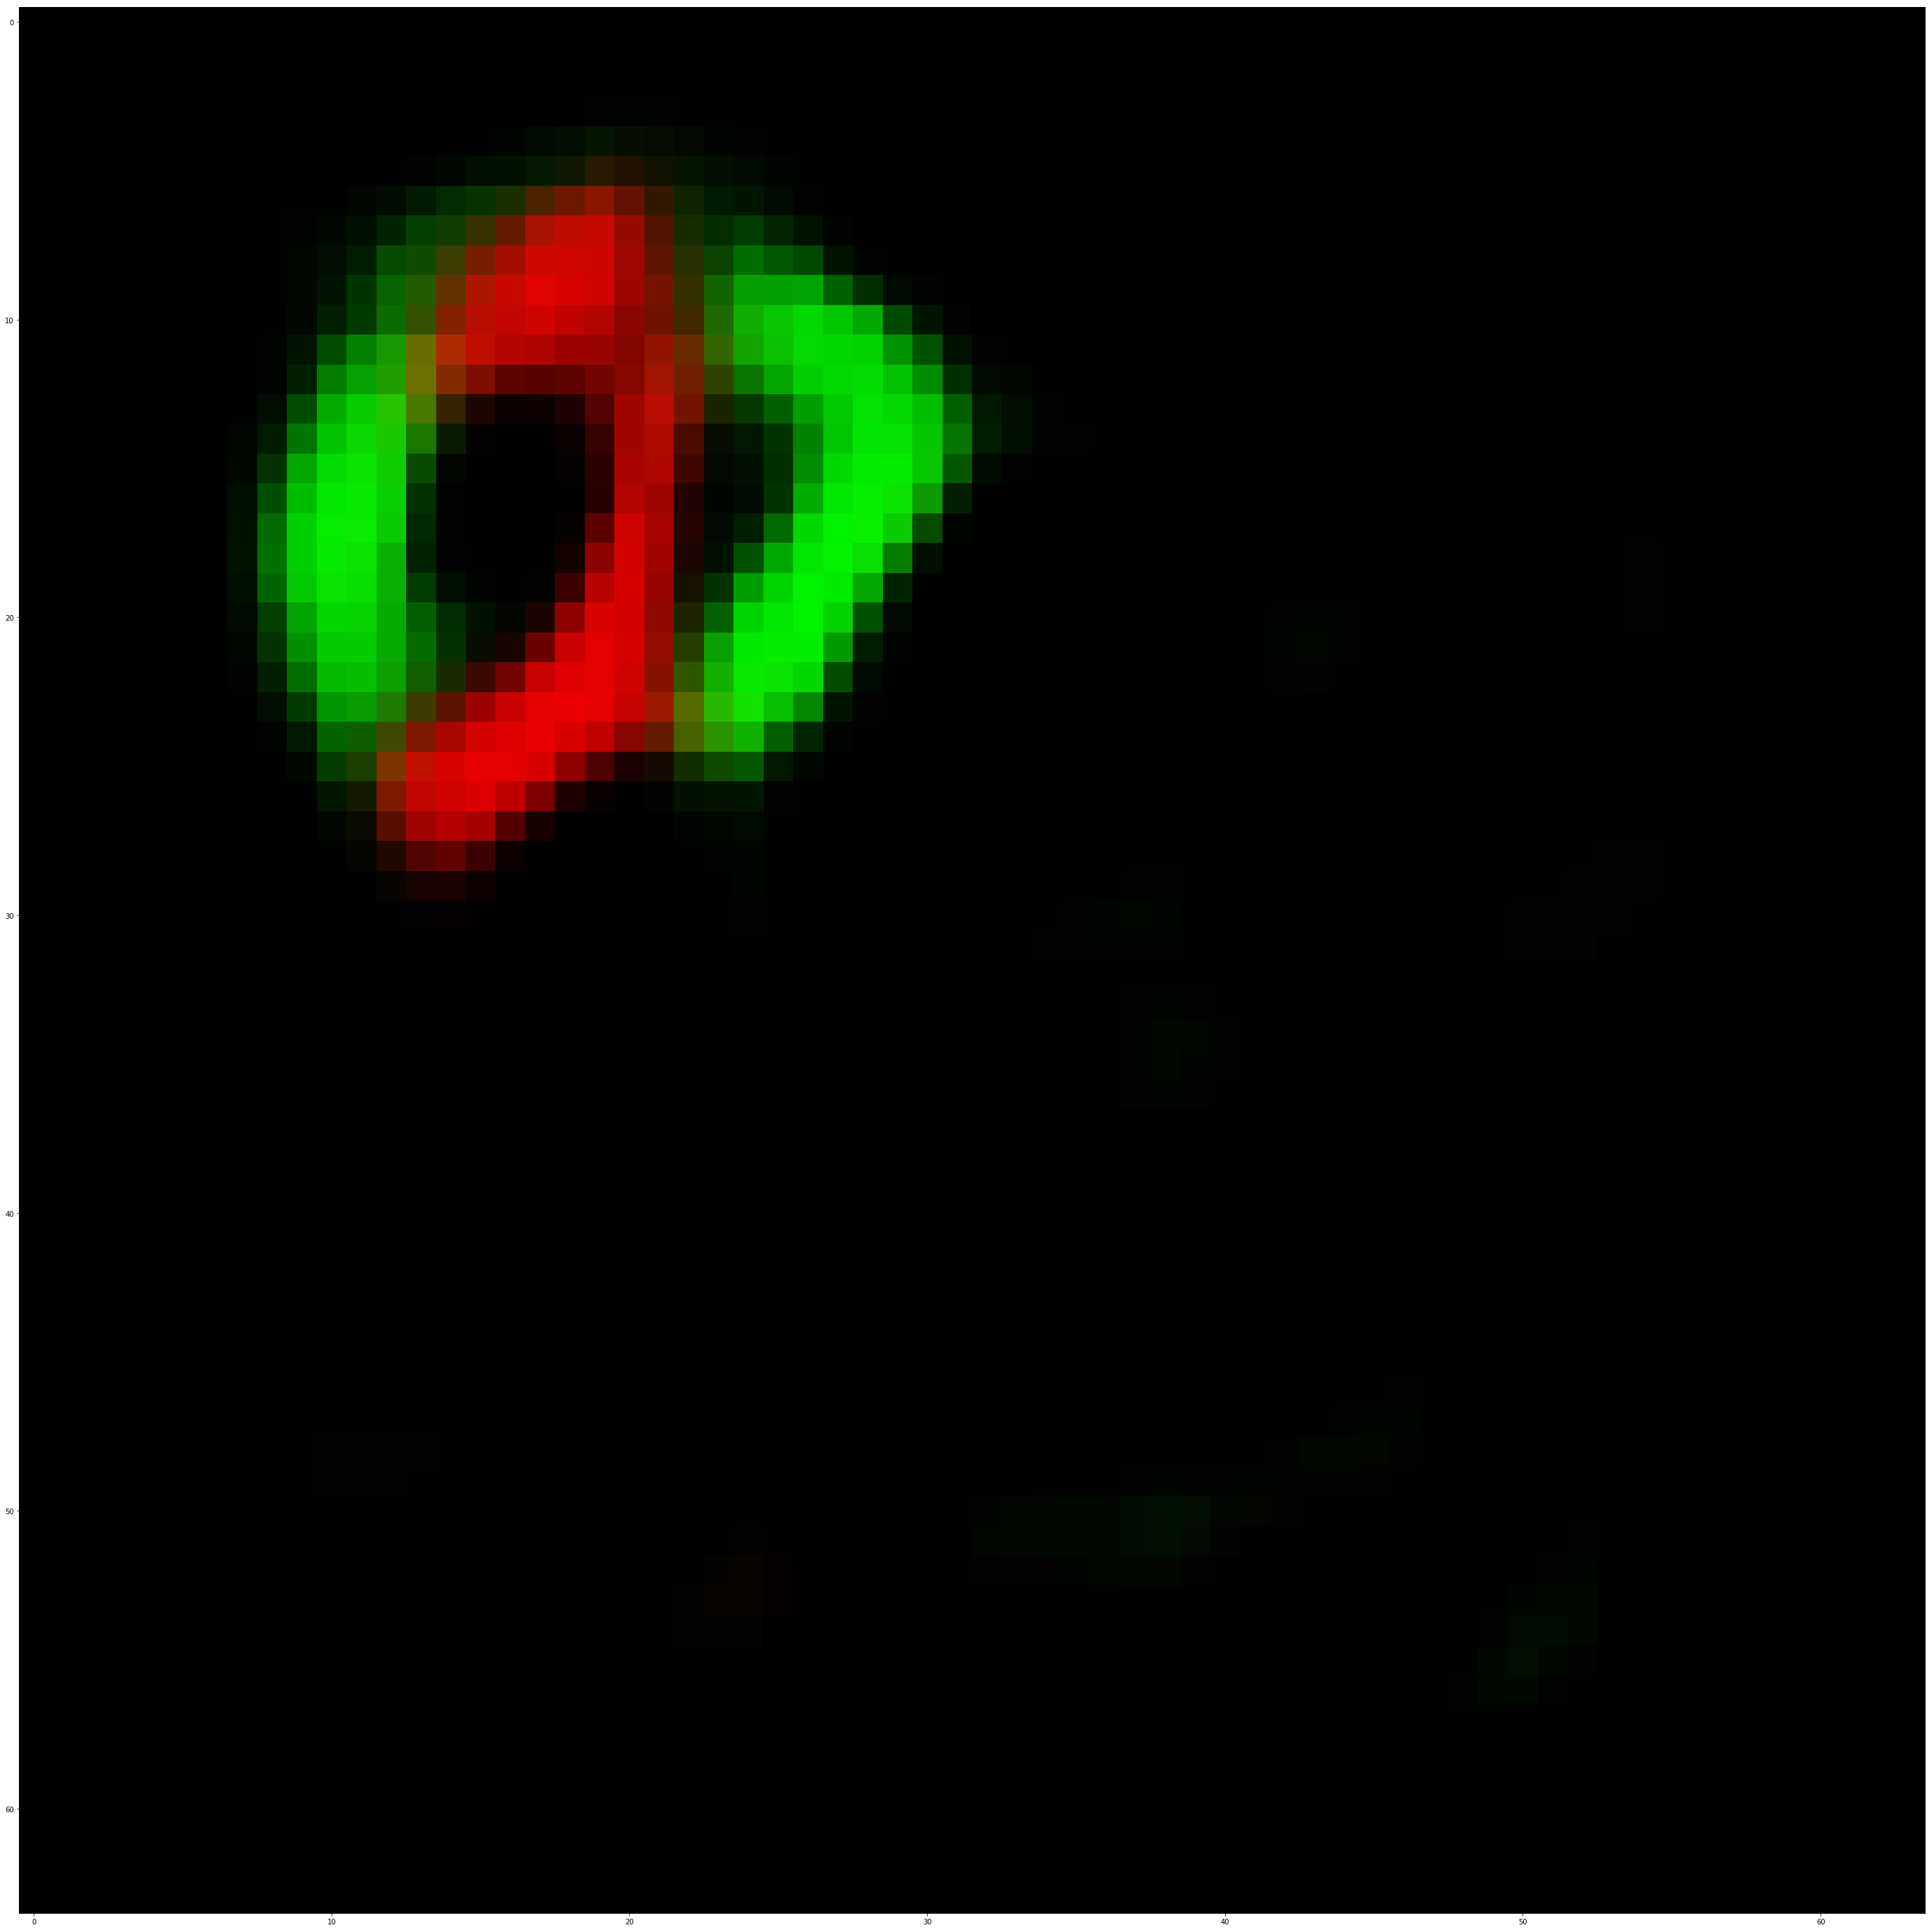

In [105]:
tf.reset_default_graph()    

model = autoencoder_conv_diff(learning_rate=40, weight_decay=0.000)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    start = time.time()
    
    my_run_model(sess, model, epochs=1000, batch_size=5 ,is_training=True, n_seq=5,valset_check=True,is_save=False) # autoencoder_conv(learning_rate=40, weight_decay=0.000)  
    #my_run_model(sess, model, epochs=500, batch_size=100 ,is_training=True, n_seq=1000)

In [14]:
class autoencoder_conv_diff(object):    
    def __init__(self, learning_rate=40, weight_decay=0.000):
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
        self.X = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.is_train = tf.placeholder(tf.bool)
        
        self.layer = tf.layers.conv2d(self.X, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', name="en_conv1", trainable=False , kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.layers.conv2d(self.layer, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same',  name="en_conv2", trainable=False, kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.contrib.layers.flatten(self.X)
        
        
        self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="en_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="test", trainable=True ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        
        
        self.layer = tf.layers.dense(self.layer, 16*16*32, activation='relu', name="de_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.reshape(self.layer,[-1,16,16,32])
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=32,kernel_size=5,strides=2,activation='relu',padding='same',name="de_conv1", trainable=False)
        
        
        self.Y_pred = tf.layers.conv2d_transpose(self.layer,filters=3,kernel_size=5,strides=2,activation='sigmoid',padding='same',name="de_conv2",trainable=False)
        
        
        
        
        
        #self.Y = tf.placeholder(tf.int32, [None,64,64,3])
        
        self.loss = tf.losses.mean_squared_error(self.X, self.Y_pred)
        self.mae = tf.reduce_mean(tf.math.abs(self.X-self.Y_pred))
        
        #self.loss = self.mae
        #self.loss = tf.reduce_mean(tf.square(self.X-self.Y_pred))
        
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
#        tf.summary.scalar("loss", self.loss)
#        tf.summary.scalar("mae", self.mae)
#        tf.summary.image("image_perdict",tf.clip_by_value(self.Y_pred,0,1))
            

        





In [15]:
class en_lstm_de(object):    
    def __init__(self, learning_rate=40, weight_decay=0.000):
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
        self.X = tf.placeholder(tf.float32, [None, 20 ,64, 64, 3])
        self.is_train = tf.placeholder(tf.bool)
        
        self.X_conv = tf.reshape(self.X,[-1,64,64,3])
                
        self.layer = tf.layers.conv2d(self.X_conv, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', name="en_conv1", trainable=False , kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.layers.conv2d(self.layer, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same',  name="en_conv2", trainable=False, kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        
        self.layer = tf.contrib.layers.flatten(self.layer)        
                  
        self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="en_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        
        
        #lstm 
        
        self.layer = tf.reshape(self.layer,[-1,20,300])
       
        self.cell1 = tf.nn.rnn_cell.BasicLSTMCell(500,name="lstm_cell1")
        self.cell2 = tf.nn.rnn_cell.BasicLSTMCell(500,name="lstm_cell2")
        
        self.stacked_lstm=tf.nn.rnn_cell.MultiRNNCell([self.cell1, self.cell2])
        
        #self.state = self.stacked_lstm.zero_state(tf.shape(self.layer)[0],tf.float32)
        #self.state = self.cell1.zero_state(tf.shape(self.layer)[0],tf.float32)
        
        #print(self.layer[:,3])
        
        #self.output_list = []
        
        #for i in range(19):
        #    if i<=9:
        #        self.output, self.state = self.cell1(self.layer[:,i],self.state)
        #        print(self.output)
       # 
        #    else :
        #        self.output, self.state = self.cell1(self.output,self.state)
        #    self.output_list.append( tf.reshape(self.output,[-1,1,00]) )
            
        #self.outputs = tf.concat(1,self.output_list)
        
        self.outputs, _ = tf.nn.dynamic_rnn(self.stacked_lstm, self.layer, dtype=tf.float32)
        
        
        self.layer = tf.reshape(self.outputs,[-1,500])
        
        
        self.W = tf.Variable(tf.random_normal([500, 300],0.0, 0.1))
        self.b = tf.Variable(tf.zeros([300]))
        
        self.layer = tf.add(tf.matmul(self.layer, self.W), self.b)
        self.layer = tf.math.tanh(self.layer)
        
        #self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="lstm_out", trainable=True ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        #lstm
        
        self.layer = tf.layers.dense(self.layer, 16*16*32, activation='relu', name="de_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.reshape(self.layer,[-1,16,16,32])
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=32,kernel_size=5,strides=2,activation='relu',padding='same',name="de_conv1", trainable=False)
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=3,kernel_size=5,strides=2,activation='sigmoid',padding='same',name="de_conv2",trainable=False)
        
        self.Y_pred = tf.reshape(self.layer, [-1,20,64,64,3])
        
        self.X_seq = self.X[:,2:20]
        self.Y_seq = self.Y_pred[:,1:19]
                
        
        self.loss = tf.losses.mean_squared_error(self.X_seq, self.Y_seq)
        self.mae = tf.reduce_mean(tf.math.abs(self.X-self.Y_pred))
        
        #self.loss = self.mae
        #self.loss = tf.reduce_mean(tf.square(self.X-self.Y_pred))
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
#        tf.summary.scalar("loss", self.loss)
#        tf.summary.scalar("mae", self.mae)
#        tf.summary.image("image_perdict",tf.clip_by_value(self.Y_pred,0,1))
            


In [16]:
def my_run_lstmmodel(session, model, epochs=1, batch_size=200, is_training=False, n_seq=1000 ,max_seq=10000, valset_check=False, is_save=False ,save_path="./save_model_lstm/model.ckpt", is_continue=True):
    
    
    layer_name=["en_conv1","en_conv2","en_dense","de_conv1","de_conv2","de_dense"]
    invar_name = ["/kernel:0", "/bias:0"]
    
    ae_saving_variable_list = [ tf.get_default_graph().get_tensor_by_name(a+b) for a in layer_name for b in invar_name ]
    
    
    
    
    ae_saver = tf.train.Saver(ae_saving_variable_list)
    
    lstm_saver = tf.train.Saver()
    
    
    
    fig=plt.figure(figsize=(40, 20))
    
    dir='Data/train_sequence/'
    
    
    selected_idx=random.sample(range(max_seq), n_seq)
    
    data_path_list =[ os.path.join(dir, 'sequence%04d' % idx) for idx in selected_idx ] 

    dataset = tf.data.Dataset.from_tensor_slices(data_path_list)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=3000)
    dataset = dataset.map( lambda data_path_list: tf.py_func(read_image, [data_path_list], tf.float32))
    dataset = dataset.batch(batch_size)

    iterator = dataset.make_initializable_iterator()
    image_batch = iterator.get_next() # n 20 64 64 3
    
    #image_batch = tf.reshape(image_batch,[-1, 64, 64, 3])
    
    if is_continue:
        ckpt_path='./save_model_lstm'
    else:
        ckpt_path='./save_model'
    
    
    ckpt = tf.train.get_checkpoint_state(ckpt_path)
    
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        if is_continue:
            lstm_saver.restore(session, ckpt.model_checkpoint_path)
        else:
            ae_saver.restore(session, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(iterator.initializer)
    #merged = tf.summary.merge_all()
    #writer = tf.summary.FileWriter('./logs', session.graph)
    start_time = time.time()
    
    
    
    if is_training:
                
        for e in range(epochs):
            
            loss = 0
            mae = 0
            
            for i in range(int(n_seq/batch_size)):
                
                batch_X = sess.run(image_batch) # n 20 64 64 3
                
                _, t_loss, t_mae = session.run([model.optimizer,model.loss,model.mae],feed_dict={model.X: batch_X, model.is_train: True})
                loss += t_loss
                mae += t_mae

                if i%5==0:
                    print("epoch : {:<4}, loss:{:2.4f}, mae: {:2.4f}, {:2.2f}% of epoch".format(e+1,t_loss,t_mae,i/(n_seq/batch_size)*100 ) )         
                
            print("epoch end! --- epoch : {:<4}, loss:{:2.4f}, mae: {:2.4f} ***********".format(e+1,loss/(n_seq/batch_size),mae/(n_seq/batch_size)))
            print("running time {}".format(-start+time.time()))
            
        test_img = session.run(model.Y_seq,feed_dict={model.X: batch_X, model.is_train: True})[0,13]
        test_img = np.clip(test_img,0,1)
        
        plt.subplot(2,1,1)
        plt.imshow(test_img)
        
        test_img = batch_X[0,14]
        test_img = np.clip(test_img,0,1)

        plt.subplot(2,1,2)
        plt.imshow(test_img)

        print("Training done!")
        
        if is_save :
            lstm_saver.save(session, save_path)
        
    if valset_check:
        dir_v='Data/val_sequence/'
        
        n_seq_v=500
    
        data_path_list_v =[ os.path.join(dir_v, 'sequence%03d' % idx) for idx in range(n_seq_v) ] 

        dataset_v = tf.data.Dataset.from_tensor_slices(data_path_list_v)
        dataset_v = dataset_v.repeat()
        dataset_v = dataset_v.shuffle(buffer_size=500)
        dataset_v = dataset_v.map( lambda data_path_list_v: tf.py_func(read_image, [data_path_list_v], tf.float32))
        
        batch_size_v = 50
        dataset_v = dataset_v.batch(batch_size_v)

        iterator_v = dataset_v.make_initializable_iterator()
        image_batch_v = iterator_v.get_next()

        #image_batch_v = tf.reshape(image_batch_v,[-1, 64, 64, 3])
        sess.run(iterator_v.initializer)
        
        v_loss=0
        v_mae=0
        
        for i in range(int(n_seq_v/batch_size_v)):
            
            batch_X_v = sess.run(image_batch_v)
            
            t_loss, t_mae = session.run([model.loss,model.mae],feed_dict={model.X: batch_X_v, model.is_train: False})
            v_loss += t_loss
            v_mae += t_mae
            
        print("validset test! ---  loss:{:2.4f}, mae: {:2.4f} ***********".format(v_loss/(n_seq_v/batch_size_v),v_mae/(n_seq_v/batch_size_v)))
            


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./save_model_lstm/model.ckpt
epoch : 1   , loss:0.0037, mae: 0.0197, 0.00% of epoch
epoch : 1   , loss:0.0037, mae: 0.0188, 5.00% of epoch
epoch : 1   , loss:0.0034, mae: 0.0185, 10.00% of epoch
epoch : 1   , loss:0.0035, mae: 0.0189, 15.00% of epoch
epoch : 1   , loss:0.0035, mae: 0.0188, 20.00% of epoch
epoch : 1   , loss:0.0034, mae: 0.0190, 25.00% of epoch
epoch : 1   , loss:0.0035, mae: 0.0189, 30.00% of epoch
epoch : 1   , loss:0.0033, mae: 0.0182, 35.00% of epoch
epoch : 1   , loss:0.0035, mae: 0.0183, 40.00% of epoch
epoch : 1   , loss:0.0034, mae: 0.0186, 45.00% of epoch
epoch : 1   , loss:0.0035, mae: 0.0194, 50.00% of epoch
epoch : 1   , loss:0.0036, mae: 0.0202, 55.00% of epoch
epoch : 1   , loss:0.0032, mae: 0.0186, 60.00% of epoch
epoch :

epoch : 1   , loss:0.0031, mae: 0.0193, 0.00% of epoch
epoch : 1   , loss:0.0033, mae: 0.0202, 5.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0183, 10.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0175, 15.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0186, 20.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0182, 25.00% of epoch
epoch : 1   , loss:0.0033, mae: 0.0196, 30.00% of epoch
epoch : 1   , loss:0.0032, mae: 0.0197, 35.00% of epoch
epoch : 1   , loss:0.0030, mae: 0.0185, 40.00% of epoch
epoch : 1   , loss:0.0031, mae: 0.0183, 45.00% of epoch
epoch : 1   , loss:0.0030, mae: 0.0185, 50.00% of epoch
epoch : 1   , loss:0.0031, mae: 0.0190, 55.00% of epoch
epoch : 1   , loss:0.0031, mae: 0.0187, 60.00% of epoch
epoch : 1   , loss:0.0030, mae: 0.0191, 65.00% of epoch
epoch : 1   , loss:0.0028, mae: 0.0183, 70.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0185, 75.00% of epoch
epoch : 1   , loss:0.0027, mae: 0.0183, 80.00% of epoch
epoch : 1   , loss:0.0032, mae: 0.0200, 85.00% of 

epoch : 1   , loss:0.0026, mae: 0.0183, 20.00% of epoch
epoch : 1   , loss:0.0028, mae: 0.0188, 25.00% of epoch
epoch : 1   , loss:0.0027, mae: 0.0190, 30.00% of epoch
epoch : 1   , loss:0.0027, mae: 0.0187, 35.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0190, 40.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0190, 45.00% of epoch
epoch : 1   , loss:0.0028, mae: 0.0190, 50.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0194, 55.00% of epoch
epoch : 1   , loss:0.0028, mae: 0.0186, 60.00% of epoch
epoch : 1   , loss:0.0029, mae: 0.0195, 65.00% of epoch
epoch : 1   , loss:0.0028, mae: 0.0194, 70.00% of epoch
epoch : 1   , loss:0.0028, mae: 0.0184, 75.00% of epoch
epoch : 1   , loss:0.0024, mae: 0.0182, 80.00% of epoch
epoch : 1   , loss:0.0025, mae: 0.0187, 85.00% of epoch
epoch : 1   , loss:0.0026, mae: 0.0198, 90.00% of epoch
epoch : 1   , loss:0.0025, mae: 0.0193, 95.00% of epoch
epoch end! --- epoch : 1   , loss:0.0027, mae: 0.0191 ***********
running time 11160.655323028564
epoch 

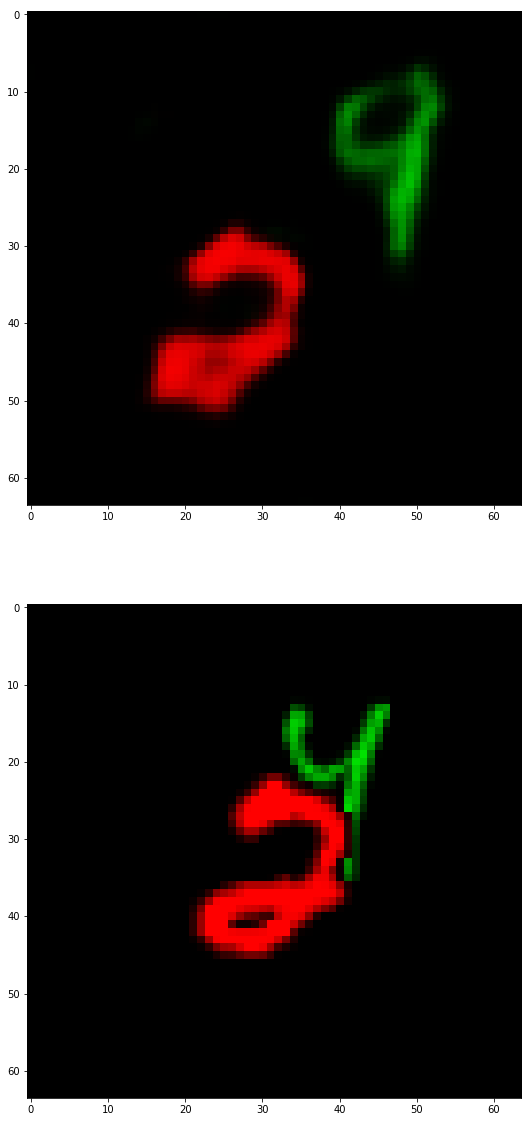

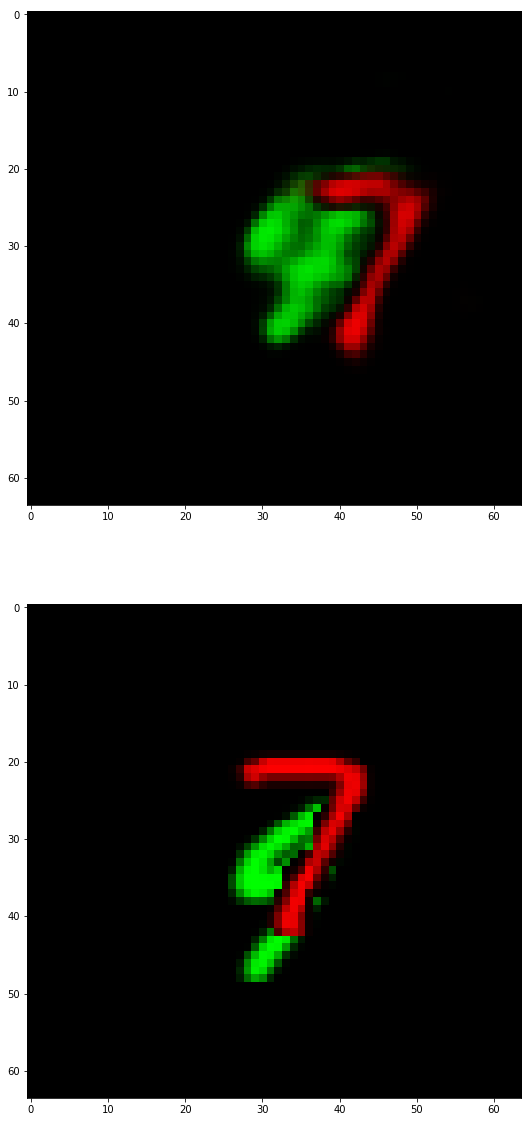

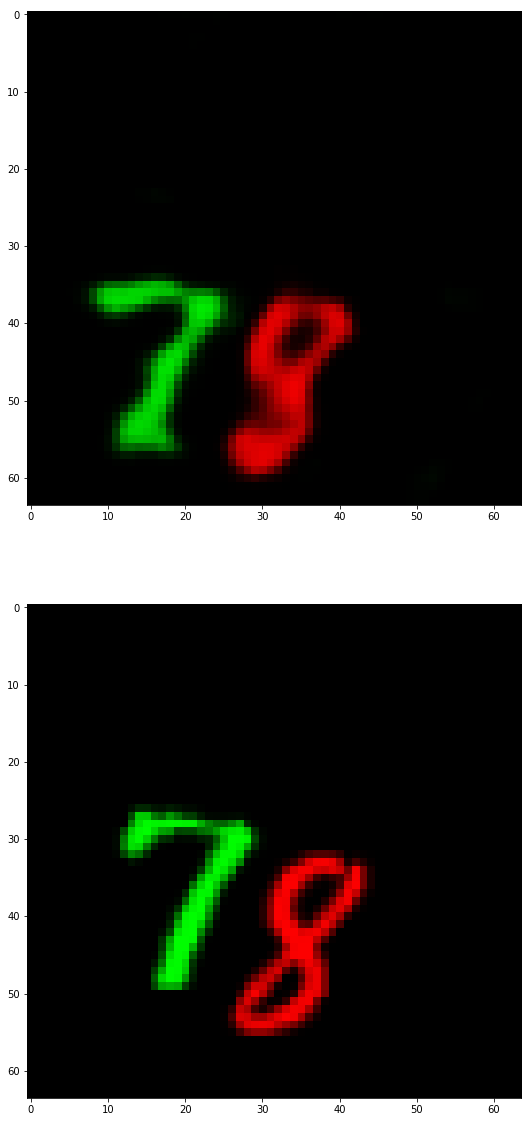

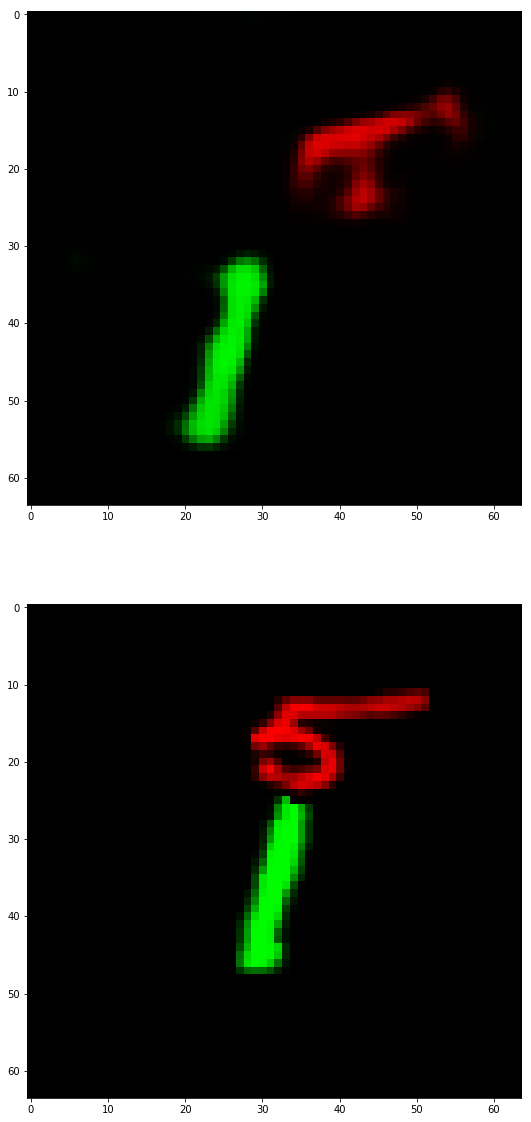

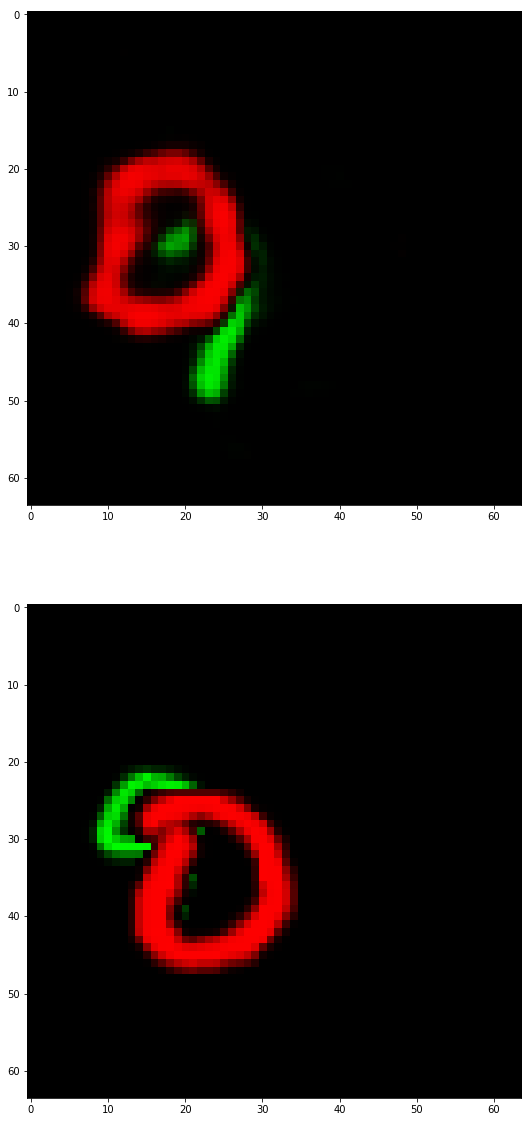

In [234]:
for i in range(5):
    tf.reset_default_graph()    

    model = en_lstm_de(learning_rate=0.003, weight_decay=0.000)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        my_run_lstmmodel(sess, model, epochs=3, batch_size=50 ,is_training=True, n_seq=5000,max_seq=10000 ,valset_check=True, is_save=True,is_continue=True) # autoencoder_conv(learning_rate=40, weight_decay=0.000)  


In [17]:
class en_lstm_de_inferr(object):    
    def __init__(self, learning_rate=40, weight_decay=0.000):
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
        self.X = tf.placeholder(tf.float32, [None, 20 ,64, 64, 3])
        self.is_train = tf.placeholder(tf.bool)
        
        self.X_conv = tf.reshape(self.X,[-1,64,64,3])
                
        self.layer = tf.layers.conv2d(self.X_conv, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', name="en_conv1", trainable=False , kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.layers.conv2d(self.layer, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same',  name="en_conv2", trainable=False, kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        
        self.layer = tf.contrib.layers.flatten(self.layer)        
                  
        self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="en_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        
        
        #lstm 
        
        self.W = tf.Variable(tf.random_normal([500, 300],0.0, 0.1))
        self.b = tf.Variable(tf.zeros([300]))

        
        self.layer = tf.reshape(self.layer,[-1,20,300])
       
        self.cell1 = tf.nn.rnn_cell.BasicLSTMCell(500,name="lstm_cell1")
        self.cell2 = tf.nn.rnn_cell.BasicLSTMCell(500,name="lstm_cell2")
        
        self.stacked_lstm=tf.nn.rnn_cell.MultiRNNCell([self.cell1, self.cell2])
        
        
        self.before_outputs, self.state = tf.nn.dynamic_rnn(self.stacked_lstm, self.layer[:,0:10], dtype=tf.float32)
        
        
        self.output_list = []
        self.output=self.before_outputs[:,9]
        print(self.before_outputs)
        print(self.output)
        self.output = tf.add(tf.matmul(self.output, self.W), self.b)
        self.output = tf.math.tanh(self.output)        
        
        
        for i in range(10):
            self.output, self.state = self.stacked_lstm(self.output,self.state)
            self.output = tf.add(tf.matmul(self.output, self.W), self.b)
            self.output = tf.math.tanh(self.output)
            if i==0 :
                self.outputs =  tf.reshape(self.output,[-1,1,300])
                print(self.outputs)
            else :
                self.outputs = tf.concat([self.outputs, tf.reshape(self.output,[-1,1,300])],1)
                print(self.outputs)
                
            #self.output_list.append( tf.reshape(self.output,[-1,1,300]) )
        
        
        self.before_outputs = tf.reshape(self.before_outputs, [-1,500])
        self.before_outputs = tf.add(tf.matmul(self.before_outputs, self.W), self.b)
        self.before_outputs = tf.math.tanh(self.before_outputs)     
        
        self.before_outputs = tf.reshape(self.before_outputs, [-1,10,300])
        
        self.outputs = tf.concat([self.before_outputs, self.outputs],1)
        
        self.layer = tf.reshape(self.outputs,[-1,300])
        
        
        
        
        
        #self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="lstm_out", trainable=True ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        #lstm
        
        self.layer = tf.layers.dense(self.layer, 16*16*32, activation='relu', name="de_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.reshape(self.layer,[-1,16,16,32])
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=32,kernel_size=5,strides=2,activation='relu',padding='same',name="de_conv1", trainable=False)
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=3,kernel_size=5,strides=2,activation='sigmoid',padding='same',name="de_conv2",trainable=False)
        
        self.Y_pred = tf.reshape(self.layer, [-1,20,64,64,3])
        
        self.X_seq = self.X[:,2:20]
        self.Y_seq = self.Y_pred[:,1:19]
                
        
        self.loss = tf.losses.mean_squared_error(self.X_seq, self.Y_seq)
        self.mae = tf.reduce_mean(tf.math.abs(self.X-self.Y_pred))
        
        #self.loss = self.mae
        #self.loss = tf.reduce_mean(tf.square(self.X-self.Y_pred))
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
#        tf.summary.scalar("loss", self.loss)
#        tf.summary.scalar("mae", self.mae)
#        tf.summary.image("image_perdict",tf.clip_by_value(self.Y_pred,0,1))
            


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Tensor("rnn/transpose_1:0", shape=(?, 10, 500), dtype=float32)
Tensor("strided_slice_1:0", shape=(?, 500), dtype=float32)
Tensor("Reshape_2:0", shape=(?, 1, 300), dtype=float32)
Tensor("concat:0", shape=(?, 2, 300), dtype=float32)
Tensor("concat_1:0", shape=(?, 3, 300), dtype=float32)
Tensor("concat_2:0", shape=(?, 4, 300), dtype=float32)
Tensor("concat_3:0", shape=(?, 5, 300), dtype=float32)
Tensor("concat_4:0", shape=(?, 6, 300), dtype=float32)
Tensor("concat_5:0", shape=(?, 7, 300), dtype=float32)
Tensor("concat_6:0", shape=(?, 8, 300), dtype=float32)
Tensor("concat_7:0", shape=(?, 9, 300), dtype=float32)
Tensor("concat_8:0", shape=(?, 10, 300), dtype=float32)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./save_model_lstm/model.ckpt
epoch : 1   , loss:0.0057, mae: 0.0201, 0.00% of epoch
epoch 

epoch : 7   , loss:0.0049, mae: 0.0192, 0.00% of epoch
epoch : 7   , loss:0.0050, mae: 0.0200, 5.00% of epoch
epoch : 7   , loss:0.0050, mae: 0.0206, 10.00% of epoch
epoch : 7   , loss:0.0052, mae: 0.0220, 15.00% of epoch
epoch : 7   , loss:0.0051, mae: 0.0199, 20.00% of epoch
epoch : 7   , loss:0.0052, mae: 0.0206, 25.00% of epoch
epoch : 7   , loss:0.0048, mae: 0.0192, 30.00% of epoch
epoch : 7   , loss:0.0052, mae: 0.0207, 35.00% of epoch
epoch : 7   , loss:0.0051, mae: 0.0200, 40.00% of epoch
epoch : 7   , loss:0.0054, mae: 0.0216, 45.00% of epoch
epoch : 7   , loss:0.0049, mae: 0.0188, 50.00% of epoch
epoch : 7   , loss:0.0047, mae: 0.0195, 55.00% of epoch
epoch : 7   , loss:0.0051, mae: 0.0198, 60.00% of epoch
epoch : 7   , loss:0.0048, mae: 0.0192, 65.00% of epoch
epoch : 7   , loss:0.0049, mae: 0.0197, 70.00% of epoch
epoch : 7   , loss:0.0051, mae: 0.0207, 75.00% of epoch
epoch : 7   , loss:0.0046, mae: 0.0194, 80.00% of epoch
epoch : 7   , loss:0.0046, mae: 0.0194, 85.00% of 

epoch : 13  , loss:0.0047, mae: 0.0200, 85.00% of epoch
epoch : 13  , loss:0.0045, mae: 0.0203, 90.00% of epoch
epoch : 13  , loss:0.0044, mae: 0.0192, 95.00% of epoch
epoch end! --- epoch : 13  , loss:0.0044, mae: 0.0197 ***********
running time 16044.513694524765
epoch : 14  , loss:0.0045, mae: 0.0190, 0.00% of epoch
epoch : 14  , loss:0.0043, mae: 0.0193, 5.00% of epoch
epoch : 14  , loss:0.0043, mae: 0.0197, 10.00% of epoch
epoch : 14  , loss:0.0043, mae: 0.0203, 15.00% of epoch
epoch : 14  , loss:0.0041, mae: 0.0190, 20.00% of epoch
epoch : 14  , loss:0.0043, mae: 0.0198, 25.00% of epoch
epoch : 14  , loss:0.0044, mae: 0.0195, 30.00% of epoch
epoch : 14  , loss:0.0044, mae: 0.0190, 35.00% of epoch
epoch : 14  , loss:0.0044, mae: 0.0198, 40.00% of epoch
epoch : 14  , loss:0.0043, mae: 0.0189, 45.00% of epoch
epoch : 14  , loss:0.0046, mae: 0.0201, 50.00% of epoch
epoch : 14  , loss:0.0044, mae: 0.0199, 55.00% of epoch
epoch : 14  , loss:0.0044, mae: 0.0198, 60.00% of epoch
epoch : 

epoch : 20  , loss:0.0039, mae: 0.0193, 60.00% of epoch
epoch : 20  , loss:0.0039, mae: 0.0200, 65.00% of epoch
epoch : 20  , loss:0.0039, mae: 0.0202, 70.00% of epoch
epoch : 20  , loss:0.0038, mae: 0.0198, 75.00% of epoch
epoch : 20  , loss:0.0040, mae: 0.0186, 80.00% of epoch
epoch : 20  , loss:0.0043, mae: 0.0204, 85.00% of epoch
epoch : 20  , loss:0.0041, mae: 0.0200, 90.00% of epoch
epoch : 20  , loss:0.0040, mae: 0.0189, 95.00% of epoch
epoch end! --- epoch : 20  , loss:0.0040, mae: 0.0196 ***********
running time 16323.46024274826
epoch : 21  , loss:0.0039, mae: 0.0191, 0.00% of epoch
epoch : 21  , loss:0.0040, mae: 0.0198, 5.00% of epoch
epoch : 21  , loss:0.0040, mae: 0.0189, 10.00% of epoch
epoch : 21  , loss:0.0041, mae: 0.0200, 15.00% of epoch
epoch : 21  , loss:0.0038, mae: 0.0192, 20.00% of epoch
epoch : 21  , loss:0.0040, mae: 0.0191, 25.00% of epoch
epoch : 21  , loss:0.0041, mae: 0.0203, 30.00% of epoch
epoch : 21  , loss:0.0038, mae: 0.0189, 35.00% of epoch
epoch : 2

epoch : 27  , loss:0.0036, mae: 0.0183, 35.00% of epoch
epoch : 27  , loss:0.0038, mae: 0.0201, 40.00% of epoch
epoch : 27  , loss:0.0039, mae: 0.0198, 45.00% of epoch
epoch : 27  , loss:0.0037, mae: 0.0193, 50.00% of epoch
epoch : 27  , loss:0.0036, mae: 0.0196, 55.00% of epoch
epoch : 27  , loss:0.0037, mae: 0.0199, 60.00% of epoch
epoch : 27  , loss:0.0036, mae: 0.0197, 65.00% of epoch
epoch : 27  , loss:0.0039, mae: 0.0202, 70.00% of epoch
epoch : 27  , loss:0.0038, mae: 0.0196, 75.00% of epoch
epoch : 27  , loss:0.0037, mae: 0.0193, 80.00% of epoch
epoch : 27  , loss:0.0039, mae: 0.0203, 85.00% of epoch
epoch : 27  , loss:0.0038, mae: 0.0201, 90.00% of epoch
epoch : 27  , loss:0.0035, mae: 0.0189, 95.00% of epoch
epoch end! --- epoch : 27  , loss:0.0037, mae: 0.0195 ***********
running time 16601.92263698578
epoch : 28  , loss:0.0037, mae: 0.0195, 0.00% of epoch
epoch : 28  , loss:0.0036, mae: 0.0193, 5.00% of epoch
epoch : 28  , loss:0.0036, mae: 0.0204, 10.00% of epoch
epoch : 2

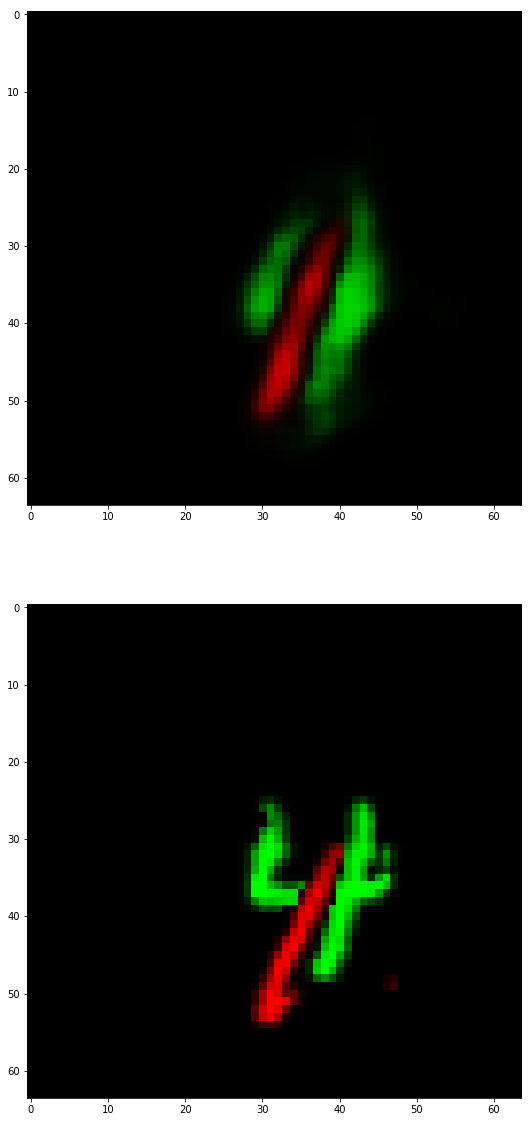

In [289]:
for i in range(1):
    tf.reset_default_graph()    

    model = en_lstm_de_inferr(learning_rate=0.003, weight_decay=0.000)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        my_run_lstmmodel(sess, model, epochs=10, batch_size=50 ,is_training=True, n_seq=5000,max_seq=10000 ,valset_check=True, is_save=True,is_continue=True) # autoencoder_conv(learning_rate=40, weight_decay=0.000)  


In [18]:
class en_lstm_de_inferr_output(object):    
    def __init__(self, learning_rate=40, weight_decay=0.000):
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
        self.X = tf.placeholder(tf.float32, [None, 10 ,64, 64, 3])
        self.is_train = tf.placeholder(tf.bool)
        
        self.X_conv = tf.reshape(self.X,[-1,64,64,3])
                
        self.layer = tf.layers.conv2d(self.X_conv, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same', name="en_conv1", trainable=False , kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        self.layer = tf.layers.conv2d(self.layer, filters = 32, kernel_size = (5, 5), strides=1, activation='relu', padding='same',  name="en_conv2", trainable=False, kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay) )
        
        self.layer = tf.layers.max_pooling2d(self.layer, pool_size=2, strides=2)
        
        
        self.layer = tf.contrib.layers.flatten(self.layer)        
                  
        self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="en_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        
        
        #lstm 
        
        self.W = tf.Variable(tf.random_normal([500, 300],0.0, 0.1))
        self.b = tf.Variable(tf.zeros([300]))

        
        self.layer = tf.reshape(self.layer,[-1,10,300])
       
        self.cell1 = tf.nn.rnn_cell.BasicLSTMCell(500,name="lstm_cell1")
        self.cell2 = tf.nn.rnn_cell.BasicLSTMCell(500,name="lstm_cell2")
        
        self.stacked_lstm=tf.nn.rnn_cell.MultiRNNCell([self.cell1, self.cell2])
        
        
        self.before_outputs, self.state = tf.nn.dynamic_rnn(self.stacked_lstm, self.layer[:,0:10], dtype=tf.float32)
        
        
        self.output_list = []
        self.output=self.before_outputs[:,9]
        print(self.before_outputs)
        print(self.output)
        self.output = tf.add(tf.matmul(self.output, self.W), self.b)
        self.output = tf.math.tanh(self.output)        
        
        
        for i in range(10):
            self.output, self.state = self.stacked_lstm(self.output,self.state)
            self.output = tf.add(tf.matmul(self.output, self.W), self.b)
            self.output = tf.math.tanh(self.output)
            if i==0 :
                self.outputs =  tf.reshape(self.output,[-1,1,300])
                print(self.outputs)
            else :
                self.outputs = tf.concat([self.outputs, tf.reshape(self.output,[-1,1,300])],1)
                print(self.outputs)
                
            #self.output_list.append( tf.reshape(self.output,[-1,1,300]) )
        
        
        self.before_outputs = tf.reshape(self.before_outputs, [-1,500])
        self.before_outputs = tf.add(tf.matmul(self.before_outputs, self.W), self.b)
        self.before_outputs = tf.math.tanh(self.before_outputs)     
        
        self.before_outputs = tf.reshape(self.before_outputs, [-1,10,300])
        
        self.outputs = tf.concat([self.before_outputs, self.outputs],1)
        
        self.layer = tf.reshape(self.outputs,[-1,300])
        
        
        
        
        
        #self.layer = tf.layers.dense(self.layer, 300, activation='tanh', name="lstm_out", trainable=True ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        #lstm
        
        self.layer = tf.layers.dense(self.layer, 16*16*32, activation='relu', name="de_dense", trainable=False ,kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
        
        self.layer = tf.reshape(self.layer,[-1,16,16,32])
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=32,kernel_size=5,strides=2,activation='relu',padding='same',name="de_conv1", trainable=False)
        
        self.layer = tf.layers.conv2d_transpose(self.layer,filters=3,kernel_size=5,strides=2,activation='sigmoid',padding='same',name="de_conv2",trainable=False)
        
        self.Y_pred = tf.reshape(self.layer, [-1,20,64,64,3])
        
        self.X_seq = self.X[:,1:10]
        self.Y_seq = self.Y_pred[:,2:11]
        
                
        
        self.loss = tf.losses.mean_squared_error(self.X_seq, self.Y_seq)
        self.mae = tf.reduce_mean(tf.math.abs(self.X_seq-self.Y_seq))
        
        #self.loss = self.mae
        #self.loss = tf.reduce_mean(tf.square(self.X-self.Y_pred))
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
#        tf.summary.scalar("loss", self.loss)
#        tf.summary.scalar("mae", self.mae)
#        tf.summary.image("image_perdict",tf.clip_by_value(self.Y_pred,0,1))
            


In [19]:
def read_image_test(path):
    data = np.zeros([ 10, 64, 64, 3],dtype=np.float32)
    path=path.decode("utf-8")
    for t in range(10):
        img_path = os.path.join(path, 'frames%02d.png'% t) 
        data[t] = np.array(Image.open(img_path)) / 255.0
    
    return data


def my_run_lstmmodel_output(session, model, epochs=1, batch_size=200, is_training=False, is_continue=True, test=True):
    
    
    lstm_saver = tf.train.Saver()
    
    fig=plt.figure(figsize=(40, 20))
    
    
  
    ckpt_path='./save_model_lstm'
    ckpt = tf.train.get_checkpoint_state(ckpt_path)
    
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        lstm_saver.restore(session, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    start_time = time.time()
    
    
    
    if test:
        dir_v='Data/test_sequence/'
        
        n_seq_v=500
        #n_seq_v=1
    
        data_path_list_v =[ os.path.join(dir_v, 'sequence%03d' % idx) for idx in range(n_seq_v) ] 

        dataset_v = tf.data.Dataset.from_tensor_slices(data_path_list_v)
        dataset_v = dataset_v.repeat()
        dataset_v = dataset_v.map( lambda data_path_list_v: tf.py_func(read_image_test, [data_path_list_v], tf.float32))
        
        batch_size_v = 1
        dataset_v = dataset_v.batch(batch_size_v)

        iterator_v = dataset_v.make_initializable_iterator()
        image_batch_v = iterator_v.get_next()

        #image_batch_v = tf.reshape(image_batch_v,[-1, 64, 64, 3])
        sess.run(iterator_v.initializer)
        
        v_loss=0
        v_mae=0
        
        for i in range(int(n_seq_v/batch_size_v)):
            
            batch_X_v = sess.run(image_batch_v)
        
            
            test_img,t_loss, t_mae = session.run([model.Y_pred,model.loss,model.mae],feed_dict={model.X: batch_X_v, model.is_train: False})
            v_loss += t_loss
            v_mae += t_mae
            print("loss:{:2.4f}, mae: {:2.4f}".format(t_loss,v_mae))
            print(test_img.shape)
            
            for j in range(10):
                img_out = np.clip((test_img[0,9+j]*255).astype(int),0,255).astype(np.uint8)
                print(img_out.shape)
                img_out = Image.fromarray(img_out)
                i
                img_out.save(os.path.join("./test_predicted","sequence%03d"% i,"frames%02d.png"%j ))
                
            
            
        print("validset test! ---  loss:{:2.4f}, mae: {:2.4f} ***********".format(v_loss/(n_seq_v/batch_size_v),v_mae/(n_seq_v/batch_size_v)))
        
        

In [20]:
for i in range(1):
    tf.reset_default_graph()    

    model = en_lstm_de_inferr_output(learning_rate=0.003, weight_decay=0.000)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        my_run_lstmmodel_output(sess, model, epochs=1, batch_size=1 ,is_training=False,is_continue=True,test=True) # autoencoder_conv(learning_rate=40, weight_decay=0.000) 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use keras.layers.flatten instead.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please

loss:0.0164, mae: 0.6432
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0115, mae: 0.6636
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0103, mae: 0.6825
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0251, mae: 0.7199
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0187, mae: 0.7475
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0141, mae: 0.7712
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0124, mae

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0156, mae: 2.0678
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0181, mae: 2.0962
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0198, mae: 2.1250
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0228, mae: 2.1576
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0198, mae: 2.1857
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0184, mae: 2.2163
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64,

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0149, mae: 3.4081
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0168, mae: 3.4347
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0128, mae: 3.4548
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0175, mae: 3.4819
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0163, mae: 3.5094
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0148, mae: 3.5311
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64,

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0267, mae: 4.8578
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0213, mae: 4.8885
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0206, mae: 4.9182
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0215, mae: 4.9514
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0127, mae: 4.9719
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0175, mae: 4.9995
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64,

loss:0.0222, mae: 6.2107
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0121, mae: 6.2311
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0197, mae: 6.2602
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0101, mae: 6.2774
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0213, mae: 6.3090
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0169, mae: 6.3358
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0166, mae

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0115, mae: 7.5600
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0171, mae: 7.5872
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0147, mae: 7.6091
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0174, mae: 7.6339
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0252, mae: 7.6695
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0159, mae: 7.6942
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64,

(64, 64, 3)
loss:0.0185, mae: 8.9639
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0167, mae: 8.9897
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0226, mae: 9.0214
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0190, mae: 9.0493
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0124, mae: 9.0718
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0205, mae: 9.1029
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0060, mae: 10.3712
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0158, mae: 10.3958
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0146, mae: 10.4200
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0204, mae: 10.4509
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0142, mae: 10.4756
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0153, mae: 10.4988
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0194, mae: 11.6965
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0266, mae: 11.7344
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0132, mae: 11.7563
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0188, mae: 11.7829
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0147, mae: 11.8053
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0166, mae: 11.8309
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3

loss:0.0153, mae: 13.1406
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0213, mae: 13.1707
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0180, mae: 13.1982
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
loss:0.0160, mae: 13.2241
(1, 20, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
validset test! ---  loss:0.0170, mae: 0.0264 ***********


<Figure size 2880x1440 with 0 Axes>

In [ ]:
# saving image
# new_im = Image.fromarray(np_im)
# new_im.save("numpy_altered_sample2.png")
# seq_list = ['sequence%03d' % i for i in range(500)]
# os.path.join("./test_predicted",i)



In [28]:
import os
from PIL import Image
import numpy as np
import pandas as pd


root_dir = './test_predicted/'
save_dir = './'

seq_list = ['sequence%03d' % i for i in range(500)]

print(seq_list)

columnNames = ['pixel_value']

total_result = np.zeros([500 * 10 * 64 * 64 * 3])
total_idx = 0
frame_index = []
for l_idx, l in enumerate(seq_list):
    now_dir = os.path.join(root_dir, l)
    frame_list = [os.path.join(now_dir, f) for f in sorted(os.listdir(now_dir))]
    print(frame_list)
    if len(frame_list) != 10:
        print(len(frame_list))
        print("Check your output")
        break
    else:
        for f_idx, f in enumerate(frame_list):
            rawData = np.array(Image.open(f))
            frame_index.append(l + '_' + f.split('/')[-1])
            rawData = rawData.flatten()
            total_result[total_idx * 64 * 64 * 3:(total_idx + 1) * 64 * 64 * 3] = rawData

            total_idx += 1

train_data = pd.DataFrame(data=total_result, columns=columnNames)
train_data.insert(loc=0, column='pixel_index', value=range(500 * 10 * 64 * 64 * 3))
train_data.to_csv(os.path.join(save_dir, "submission.csv"), index=False)

['sequence000', 'sequence001', 'sequence002', 'sequence003', 'sequence004', 'sequence005', 'sequence006', 'sequence007', 'sequence008', 'sequence009', 'sequence010', 'sequence011', 'sequence012', 'sequence013', 'sequence014', 'sequence015', 'sequence016', 'sequence017', 'sequence018', 'sequence019', 'sequence020', 'sequence021', 'sequence022', 'sequence023', 'sequence024', 'sequence025', 'sequence026', 'sequence027', 'sequence028', 'sequence029', 'sequence030', 'sequence031', 'sequence032', 'sequence033', 'sequence034', 'sequence035', 'sequence036', 'sequence037', 'sequence038', 'sequence039', 'sequence040', 'sequence041', 'sequence042', 'sequence043', 'sequence044', 'sequence045', 'sequence046', 'sequence047', 'sequence048', 'sequence049', 'sequence050', 'sequence051', 'sequence052', 'sequence053', 'sequence054', 'sequence055', 'sequence056', 'sequence057', 'sequence058', 'sequence059', 'sequence060', 'sequence061', 'sequence062', 'sequence063', 'sequence064', 'sequence065', 'sequence

['./test_predicted/sequence051/frames00.png', './test_predicted/sequence051/frames01.png', './test_predicted/sequence051/frames02.png', './test_predicted/sequence051/frames03.png', './test_predicted/sequence051/frames04.png', './test_predicted/sequence051/frames05.png', './test_predicted/sequence051/frames06.png', './test_predicted/sequence051/frames07.png', './test_predicted/sequence051/frames08.png', './test_predicted/sequence051/frames09.png']
['./test_predicted/sequence052/frames00.png', './test_predicted/sequence052/frames01.png', './test_predicted/sequence052/frames02.png', './test_predicted/sequence052/frames03.png', './test_predicted/sequence052/frames04.png', './test_predicted/sequence052/frames05.png', './test_predicted/sequence052/frames06.png', './test_predicted/sequence052/frames07.png', './test_predicted/sequence052/frames08.png', './test_predicted/sequence052/frames09.png']
['./test_predicted/sequence053/frames00.png', './test_predicted/sequence053/frames01.png', './test

['./test_predicted/sequence105/frames00.png', './test_predicted/sequence105/frames01.png', './test_predicted/sequence105/frames02.png', './test_predicted/sequence105/frames03.png', './test_predicted/sequence105/frames04.png', './test_predicted/sequence105/frames05.png', './test_predicted/sequence105/frames06.png', './test_predicted/sequence105/frames07.png', './test_predicted/sequence105/frames08.png', './test_predicted/sequence105/frames09.png']
['./test_predicted/sequence106/frames00.png', './test_predicted/sequence106/frames01.png', './test_predicted/sequence106/frames02.png', './test_predicted/sequence106/frames03.png', './test_predicted/sequence106/frames04.png', './test_predicted/sequence106/frames05.png', './test_predicted/sequence106/frames06.png', './test_predicted/sequence106/frames07.png', './test_predicted/sequence106/frames08.png', './test_predicted/sequence106/frames09.png']
['./test_predicted/sequence107/frames00.png', './test_predicted/sequence107/frames01.png', './test

['./test_predicted/sequence161/frames00.png', './test_predicted/sequence161/frames01.png', './test_predicted/sequence161/frames02.png', './test_predicted/sequence161/frames03.png', './test_predicted/sequence161/frames04.png', './test_predicted/sequence161/frames05.png', './test_predicted/sequence161/frames06.png', './test_predicted/sequence161/frames07.png', './test_predicted/sequence161/frames08.png', './test_predicted/sequence161/frames09.png']
['./test_predicted/sequence162/frames00.png', './test_predicted/sequence162/frames01.png', './test_predicted/sequence162/frames02.png', './test_predicted/sequence162/frames03.png', './test_predicted/sequence162/frames04.png', './test_predicted/sequence162/frames05.png', './test_predicted/sequence162/frames06.png', './test_predicted/sequence162/frames07.png', './test_predicted/sequence162/frames08.png', './test_predicted/sequence162/frames09.png']
['./test_predicted/sequence163/frames00.png', './test_predicted/sequence163/frames01.png', './test

['./test_predicted/sequence216/frames00.png', './test_predicted/sequence216/frames01.png', './test_predicted/sequence216/frames02.png', './test_predicted/sequence216/frames03.png', './test_predicted/sequence216/frames04.png', './test_predicted/sequence216/frames05.png', './test_predicted/sequence216/frames06.png', './test_predicted/sequence216/frames07.png', './test_predicted/sequence216/frames08.png', './test_predicted/sequence216/frames09.png']
['./test_predicted/sequence217/frames00.png', './test_predicted/sequence217/frames01.png', './test_predicted/sequence217/frames02.png', './test_predicted/sequence217/frames03.png', './test_predicted/sequence217/frames04.png', './test_predicted/sequence217/frames05.png', './test_predicted/sequence217/frames06.png', './test_predicted/sequence217/frames07.png', './test_predicted/sequence217/frames08.png', './test_predicted/sequence217/frames09.png']
['./test_predicted/sequence218/frames00.png', './test_predicted/sequence218/frames01.png', './test

['./test_predicted/sequence273/frames00.png', './test_predicted/sequence273/frames01.png', './test_predicted/sequence273/frames02.png', './test_predicted/sequence273/frames03.png', './test_predicted/sequence273/frames04.png', './test_predicted/sequence273/frames05.png', './test_predicted/sequence273/frames06.png', './test_predicted/sequence273/frames07.png', './test_predicted/sequence273/frames08.png', './test_predicted/sequence273/frames09.png']
['./test_predicted/sequence274/frames00.png', './test_predicted/sequence274/frames01.png', './test_predicted/sequence274/frames02.png', './test_predicted/sequence274/frames03.png', './test_predicted/sequence274/frames04.png', './test_predicted/sequence274/frames05.png', './test_predicted/sequence274/frames06.png', './test_predicted/sequence274/frames07.png', './test_predicted/sequence274/frames08.png', './test_predicted/sequence274/frames09.png']
['./test_predicted/sequence275/frames00.png', './test_predicted/sequence275/frames01.png', './test

['./test_predicted/sequence329/frames00.png', './test_predicted/sequence329/frames01.png', './test_predicted/sequence329/frames02.png', './test_predicted/sequence329/frames03.png', './test_predicted/sequence329/frames04.png', './test_predicted/sequence329/frames05.png', './test_predicted/sequence329/frames06.png', './test_predicted/sequence329/frames07.png', './test_predicted/sequence329/frames08.png', './test_predicted/sequence329/frames09.png']
['./test_predicted/sequence330/frames00.png', './test_predicted/sequence330/frames01.png', './test_predicted/sequence330/frames02.png', './test_predicted/sequence330/frames03.png', './test_predicted/sequence330/frames04.png', './test_predicted/sequence330/frames05.png', './test_predicted/sequence330/frames06.png', './test_predicted/sequence330/frames07.png', './test_predicted/sequence330/frames08.png', './test_predicted/sequence330/frames09.png']
['./test_predicted/sequence331/frames00.png', './test_predicted/sequence331/frames01.png', './test

['./test_predicted/sequence386/frames00.png', './test_predicted/sequence386/frames01.png', './test_predicted/sequence386/frames02.png', './test_predicted/sequence386/frames03.png', './test_predicted/sequence386/frames04.png', './test_predicted/sequence386/frames05.png', './test_predicted/sequence386/frames06.png', './test_predicted/sequence386/frames07.png', './test_predicted/sequence386/frames08.png', './test_predicted/sequence386/frames09.png']
['./test_predicted/sequence387/frames00.png', './test_predicted/sequence387/frames01.png', './test_predicted/sequence387/frames02.png', './test_predicted/sequence387/frames03.png', './test_predicted/sequence387/frames04.png', './test_predicted/sequence387/frames05.png', './test_predicted/sequence387/frames06.png', './test_predicted/sequence387/frames07.png', './test_predicted/sequence387/frames08.png', './test_predicted/sequence387/frames09.png']
['./test_predicted/sequence388/frames00.png', './test_predicted/sequence388/frames01.png', './test

['./test_predicted/sequence441/frames00.png', './test_predicted/sequence441/frames01.png', './test_predicted/sequence441/frames02.png', './test_predicted/sequence441/frames03.png', './test_predicted/sequence441/frames04.png', './test_predicted/sequence441/frames05.png', './test_predicted/sequence441/frames06.png', './test_predicted/sequence441/frames07.png', './test_predicted/sequence441/frames08.png', './test_predicted/sequence441/frames09.png']
['./test_predicted/sequence442/frames00.png', './test_predicted/sequence442/frames01.png', './test_predicted/sequence442/frames02.png', './test_predicted/sequence442/frames03.png', './test_predicted/sequence442/frames04.png', './test_predicted/sequence442/frames05.png', './test_predicted/sequence442/frames06.png', './test_predicted/sequence442/frames07.png', './test_predicted/sequence442/frames08.png', './test_predicted/sequence442/frames09.png']
['./test_predicted/sequence443/frames00.png', './test_predicted/sequence443/frames01.png', './test

['./test_predicted/sequence497/frames00.png', './test_predicted/sequence497/frames01.png', './test_predicted/sequence497/frames02.png', './test_predicted/sequence497/frames03.png', './test_predicted/sequence497/frames04.png', './test_predicted/sequence497/frames05.png', './test_predicted/sequence497/frames06.png', './test_predicted/sequence497/frames07.png', './test_predicted/sequence497/frames08.png', './test_predicted/sequence497/frames09.png']
['./test_predicted/sequence498/frames00.png', './test_predicted/sequence498/frames01.png', './test_predicted/sequence498/frames02.png', './test_predicted/sequence498/frames03.png', './test_predicted/sequence498/frames04.png', './test_predicted/sequence498/frames05.png', './test_predicted/sequence498/frames06.png', './test_predicted/sequence498/frames07.png', './test_predicted/sequence498/frames08.png', './test_predicted/sequence498/frames09.png']
['./test_predicted/sequence499/frames00.png', './test_predicted/sequence499/frames01.png', './test